In [46]:
!pip install wfdb neurokit2
# numpy, scipy, matplotlib are usually pre-installed

import wfdb
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import neurokit2 as nk
import os # For navigating paths
import random


In [47]:

TARGET_FS = 200  # Hz
# FILTER_LOWCUT = 0.5  # Hz (May not be needed if using pre-filtered signal)
# FILTER_HIGHCUT = 40.0  # Hz (May not be needed)
# FILTER_ORDER = 4

SEGMENT_SAMPLES = 1000 # Final segment length for CNN (e.g., 1000 samples @ 200Hz = 5 seconds)
R2R_P2T_PIECE_SAMPLES = 200 # Length of each piece before combining 5
NUM_PIECES_COMBINE = 5

NORM_MIN = -512
NORM_MAX = 512


In [48]:

# Base path for the dataset in Kaggle
BASE_DATA_PATH = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/'

# Function to plot signals for inspection (same as before)
def plot_signal(signal, fs, title="Signal", x_label="Samples", y_label="Amplitude"):
    # If fs is None, it means the x-axis is already in samples
    if fs is not None:
        time_axis = np.arange(len(signal)) / fs
        x_input = time_axis
        if x_label == "Samples": # Default, but if fs provided, use time
             x_label_to_use = "Time (s)"
        else:
            x_label_to_use = x_label
    else:
        x_input = np.arange(len(signal))
        x_label_to_use = x_label

    plt.figure(figsize=(12, 4))
    plt.plot(x_input, signal)
    plt.title(title)
    plt.xlabel(x_label_to_use)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [49]:


def load_ecg_id_record(person_id_str, record_num_str, use_filtered=True):
    record_path_without_ext = os.path.join(BASE_DATA_PATH, person_id_str, record_num_str)
    print(f"Attempting to load record from: {record_path_without_ext}")
    try:
        # wfdb.rdsamp is returning a tuple: (signal_array, metadata_dict)
        returned_data = wfdb.rdsamp(record_path_without_ext)
        
        print(f"Type of object returned by wfdb.rdsamp: {type(returned_data)}")

        if not isinstance(returned_data, tuple) or len(returned_data) != 2:
            print("wfdb.rdsamp did not return the expected (signal, metadata) tuple.")
            return None, None

        signal_array = returned_data[0]  # The first element is the signal data
        metadata_dict = returned_data[1] # The second element is the metadata dictionary

        if use_filtered:
            # Ensure there are at least 2 columns if asking for column 1
            if signal_array.ndim == 1 or signal_array.shape[1] < 2 :
                print(f"Error: Requested filtered signal (column 1) but signal array has shape {signal_array.shape}")
                return None, None
            signal = signal_array[:, 1] 
            signal_type = "Filtered"
        else:
            signal = signal_array[:, 0] 
            signal_type = "Raw"
            
        fs = metadata_dict['fs'] # Get 'fs' from the metadata dictionary
        
        print(f"Loaded: {person_id_str}/{record_num_str} ({signal_type}), Original Fs: {fs} Hz, Signal length: {len(signal)}")
        return signal, fs # Return the selected signal column and fs
        
    except FileNotFoundError:
        print(f"Error: File not found for record {record_path_without_ext}")
        return None, None
    except Exception as e:
        print(f"General error loading record {record_path_without_ext}: {e}")
        import traceback
        traceback.print_exc()
        return None, None



Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_1
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_1 (Filtered), Original Fs: 500 Hz, Signal length: 10000
Successfully loaded signal. Shape: (10000,), FS: 500


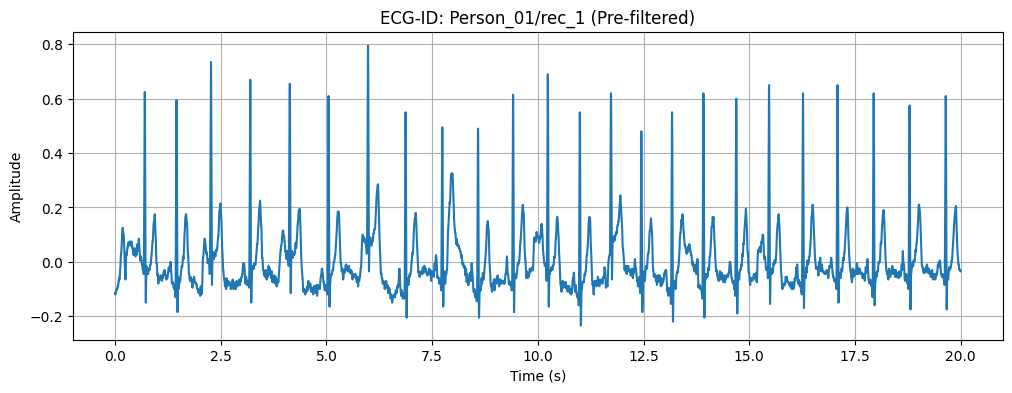

Final original_fs value: 500


In [50]:

person_id = 'Person_01'
record_num = 'rec_1'
ecg_signal, original_fs = load_ecg_id_record(person_id, record_num, use_filtered=True)

if ecg_signal is not None:
    print(f"Successfully loaded signal. Shape: {ecg_signal.shape}, FS: {original_fs}")
    plot_signal(ecg_signal, original_fs, title=f"ECG-ID: {person_id}/{record_num} (Pre-filtered)")
else:
    print("Failed to load signal (as determined by load_ecg_id_record return).")

print(f"Final original_fs value: {original_fs}")

In [51]:
import wfdb
import numpy as np
import scipy.signal as sig
# import matplotlib.pyplot as plt # Keep if needed for plotting intermediate steps
import neurokit2 as nk
import os
import random # Still useful for potential negative sampling logic later, or if you added randomization elsewhere

# --- Configuration Parameters (ensure these are defined and match your paper-based setup) ---
BASE_DATA_PATH = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/' # Make sure this is correct for your environment
TARGET_FS = 200  # Hz - Target sampling rate after resampling
SEGMENT_SAMPLES = 1000 # Final segment length for CNN input
R2R_P2T_PIECE_SAMPLES = 200 # Length of individual P-T piece after resampling
NUM_PIECES_COMBINE = 5 # Number of P-T pieces to combine (5 * 200 = 1000)
NORM_MIN = -512
NORM_MAX = 512

MAX_ORIGINAL_R2R_PIECE_LEN = 400 # samples (at TARGET_FS) - Filter out very long RR intervals

# --- Helper Function Definitions (Copy/Ensure these are here and correct) ---
# plot_signal (Optional)
# load_ecg_id_record

def plot_signal(signal, fs, title="Signal", x_label="Samples", y_label="Amplitude"):
    if fs is not None:
        time_axis = np.arange(len(signal)) / fs
        x_input = time_axis
        x_label_to_use = "Time (s)" if x_label == "Samples" else x_label
    else:
        x_input = np.arange(len(signal))
        x_label_to_use = x_label

    plt.figure(figsize=(12, 4))
    plt.plot(x_input, signal)
    plt.title(title)
    plt.xlabel(x_label_to_use)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

def resample_signal(signal, original_fs, target_fs):
    # Added print statements for better debugging
    if original_fs == target_fs:
        # print("Signal already at target frequency.") # Removed to reduce log spam
        return signal
    if signal is None or len(signal) == 0:
        print("Cannot resample an empty signal.")
        return np.array([])
    num_samples_target = int(len(signal) * target_fs / original_fs)
    if num_samples_target < 1 :
        # print(f"Target samples for resampling is {num_samples_target}, too small. Original len: {len(signal)}") # Removed to reduce log spam
        return np.array([])
    try:
        resampled_signal = sig.resample(signal, num_samples_target)
        # print(f"Resampled signal from {original_fs} Hz to {target_fs} Hz. New length: {len(resampled_signal)}") # Removed to reduce log spam
        return resampled_signal
    except Exception as e:
        print(f"Error during resampling: {e}")
        return np.array([])


def normalize_segment(segment, min_val=NORM_MIN, max_val=NORM_MAX):
    seg_min, seg_max = np.min(segment), np.max(segment)
    if seg_max == seg_min: return np.full_like(segment, (min_val + max_val) / 2.0)
    normalized = (segment - seg_min) / (seg_max - seg_min)
    normalized = normalized * (max_val - min_val) + min_val
    return normalized

def bandpass_filter(signal, fs, lowcut=0.5, highcut=40):
    """
    Applies a bandpass filter to the signal.
    """
    if signal is None or len(signal) == 0: return np.array([])
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Handle edge cases for cutoff frequencies
    if low >= high:
        # print(f"Warning: Low cutoff ({lowcut}) >= High cutoff ({highcut}). Returning empty array.")
        return np.array([])
    if low >= 1.0: # Low cutoff above Nyquist
        # print(f"Warning: Low cutoff ({lowcut}) >= Nyquist ({nyquist}). Returning empty array.")
        return np.array([])
    if high >= 1.0: # High cutoff above Nyquist
         high = 0.99 # Set to just below Nyquist

    # Using a Butterworth filter, order can be adjusted
    order = 5
    try:
        b, a = sig.butter(order, [low, high], btype='band')
        # Apply filter forward and backward to avoid phase distortion
        filtered_signal = sig.filtfilt(b, a, signal)
        return filtered_signal
    except ValueError as e:
         print(f"Filtering error: {e}")
         return np.array([])
    except np.linalg.LinAlgError as e:
         print(f"Filtering LinAlg error: {e}")
         return np.array([])
    except Exception as e:
         print(f"An unexpected filtering error occurred: {e}")
         return np.array([])


# --- R2R Segmentation Function (NEW) ---
def segment_r2r(signal, fs, target_piece_samples=R2R_P2T_PIECE_SAMPLES, num_pieces=NUM_PIECES_COMBINE, max_original_piece_len=MAX_ORIGINAL_R2R_PIECE_LEN):
    """
    Segments ECG signal based on R-peak to R-peak intervals,
    filters by original length, resamples pieces, and combines consecutive pieces.
    """
    final_segments = []
    
    # Need enough data for R-peak detection and at least NUM_PIECES_COMBINE beats
    # A typical HR is 60 bpm (1 beat/sec). 5 beats is 5 seconds. At 200Hz, 5 seconds is 1000 samples.
    # So need at least SEGMENT_SAMPLES (1000) worth of signal approximately.
    if signal is None or len(signal) < SEGMENT_SAMPLES:
        # print(f"  segment_r2r: Input signal too short ({len(signal)} samples) for segmentation.")
        return final_segments

    # 1. Detect R-peaks
    try:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
        rpeaks = rpeaks['ECG_R_Peaks']
        # Remove first/last R-peak if they are too close to signal start/end? Or let piece extraction handle?
        # Let's just use all detected R-peaks for now.
        
        if len(rpeaks) < num_pieces + 1: # Need at least 6 R-peaks to get 5 consecutive R-R intervals
             # print(f"  segment_r2r: Not enough R-peaks ({len(rpeaks)}) to form at least one {num_pieces}-piece segment.")
             return final_segments

    except Exception as e:
        # print(f"  segment_r2r: Error during neurokit2 R-peak detection: {e}")
        return final_segments

    # 2. Extract, Filter by Length, and Resample R-R Pieces
    rr_pieces_resampled = []

    # Iterate through consecutive R-peak indices (R[i] to R[i+1])
    for i in range(len(rpeaks) - 1):
        r1_idx = rpeaks[i]
        r2_idx = rpeaks[i+1]

        # Extract the piece between R1 and R2
        piece = signal[r1_idx : r2_idx]

        # Check original piece length (filter out excessively long segments, likely due to missed peaks)
        if len(piece) > 0 and len(piece) <= max_original_piece_len:
            # Resample the accepted piece to the target piece length
            resampled_piece = sig.resample(piece, target_piece_samples)

            # Check if resampling was successful and resulted in the correct size
            if len(resampled_piece) == target_piece_samples:
                rr_pieces_resampled.append(resampled_piece)
            # else: print(f"  segment_r2r: Resampling piece from {len(piece)} to {target_piece_samples} failed.")
        # else:
            # print(f"  segment_r2r: Skipping R-R piece from index {r1_idx} to {r2_idx}. Original length {len(piece)} samples (Limit: {max_original_piece_len}).")


    # print(f"  segment_r2r: Extracted, filtered, and resampled {len(rr_pieces_resampled)} valid R-R pieces (each {target_piece_samples} samples).")

    # 3. Combine Consecutive Pieces
    if len(rr_pieces_resampled) < num_pieces:
        # print(f"  segment_r2r: Not enough valid R-R pieces ({len(rr_pieces_resampled)}) to form any {num_pieces}-piece segments.")
        return final_segments # Cannot form any 5-piece segments

    # Iterate through the resampled pieces and combine consecutive groups
    for i in range(len(rr_pieces_resampled) - num_pieces + 1):
        combined_segment = np.concatenate(rr_pieces_resampled[i : i + num_pieces])
        
        # Check if concatenation yielded correct length (5*200)
        if len(combined_segment) == num_pieces * target_piece_samples:
             final_segments.append(combined_segment)
        # else: print(f"  segment_r2r: Combined segment has incorrect length {len(combined_segment)}. Expected {num_pieces * target_piece_samples}")


    # print(f"  segment_r2r: Formed {len(final_segments)} final {SEGMENT_SAMPLES}-sample segments.")

    return final_segments



In [52]:

# --- P2T Segmentation Function (NEW) ---
def segment_p2t(signal, original_fs, target_fs=TARGET_FS, piece_samples=R2R_P2T_PIECE_SAMPLES, num_pieces=NUM_PIECES_COMBINE):
    """
    Segments ECG signal based on P-peak to T-peak intervals,
    resamples pieces, and combines consecutive pieces.
    """
    final_segments = []
    
    if signal is None or len(signal) < target_fs: # Need at least 1 second of data to find peaks
        return final_segments

    # 1. Bandpass Filter (assuming the input 'signal' is already filtered from the main loop, but let's filter again defensively if needed)
    # For this setup, we assume the input 'signal' here is already the bandpass-filtered, resampled signal at target_fs.
    # So we don't need to filter/resample *inside* this function.
    # signal_processed = bandpass_filter(signal, target_fs) # Assuming signal is already filtered at target_fs
    # signal_processed = resample_signal(signal_processed, original_fs, target_fs) # Assuming signal is already resampled

    signal_processed = signal # Use the input signal directly, assuming it's ready
    fs = target_fs # Use the target_fs

    if signal_processed is None or len(signal_processed) == 0:
        print("  segment_p2t: Input signal is empty after assumed preprocessing.")
        return final_segments

    # 2. Detect Peaks and Delineate
    try:
        # Find R-peaks
        _, rpeaks = nk.ecg_peaks(signal_processed, sampling_rate=fs)
        rpeaks = rpeaks['ECG_R_Peaks']
        if len(rpeaks) < num_pieces:
             # print(f"  segment_p2t: Not enough R-peaks ({len(rpeaks)}) to form at least one {num_pieces}-piece segment.")
             return final_segments

        # Delineate waves (P, Q, R, S, T) based on R-peaks
        # Use 'wavelet' method as suggested by paper's reference [32]
        delineate_signal, waves = nk.ecg_delineate(signal_processed, rpeaks, sampling_rate=fs, method="wavelet")

        # Extract peak locations for P and T
        p_peaks = waves['ECG_P_Peaks']
        t_peaks = waves['ECG_T_Peaks']
        
        # Check if delineation was successful enough
        if p_peaks is None or t_peaks is None or len(p_peaks) == 0 or len(t_peaks) == 0:
             # print("  segment_p2t: Delineation failed to find P or T peaks.")
             return final_segments

    except Exception as e:
        # print(f"  segment_p2t: Error during neurokit2 processing: {e}")
        return final_segments

    # 3. Extract and Resample P-T Pieces
    pt_pieces_resampled = []
    
    # We need to align P, T peaks with corresponding R-peaks
    # Neurokit2's delineation usually aligns waves to the nearest R-peak index
    # Let's iterate through R-peaks and find the corresponding P and T within a reasonable window
    
    # Helper to find nearest peak index within a range
    def find_nearest_peak(peak_list, anchor_idx, search_range_samples):
        if peak_list is None or len(peak_list) == 0: return None
        search_min = max(0, anchor_idx - search_range_samples)
        search_max = min(len(signal_processed) - 1, anchor_idx + search_range_samples)
        
        valid_peaks_in_range = [p for p in peak_list if search_min <= p <= search_max]
        if not valid_peaks_in_range: return None
        
        # Find the closest one
        closest_peak = min(valid_peaks_in_range, key=lambda p: abs(p - anchor_idx))
        return closest_peak if abs(closest_peak - anchor_idx) <= search_range_samples else None

    # Define search window relative to R-peak (adjust if needed based on dataset)
    # A typical R-P interval is ~120-200ms (24-40 samples at 200Hz)
    # A typical R-T interval is ~280-440ms (56-88 samples at 200Hz)
    # A P-R interval is ~120-200ms before R. A Q-T interval is ~300-430ms after Q.
    # P is before R, T is after R. Let's search backwards from R for P, and forwards for T.
    # Need to be careful with the *beat* association.
    # Neurokit2's `ecg_delineate` tries to provide wave indices per beat.
    # Let's try accessing the waves dictionary directly first.
    
    # Assuming waves['ECG_P_Peaks'] and waves['ECG_T_Peaks'] are aligned beat-wise
    # However, these often contain indices for *all* detected P/T waves, not necessarily one per beat.
    # A safer approach might be to use the 'ECG_P_Onsets', 'ECG_T_Offsets' which are more beat-bound if available,
    # or rely on the delineate_signal output if it encodes beats (Neurokit2 delineate_signal often just has markers).
    # Let's try using the 'waves' dictionary directly for peak indices first, and then verify beat association if needed.
    
    # Let's iterate through R-peaks and find the *closest* P before R and T after R
    # within a generous window that likely contains waves from the same beat.
    max_pr_interval_samples = int(0.3 * fs) # e.g., 300ms before R
    max_rt_interval_samples = int(0.5 * fs) # e.g., 500ms after R

    valid_pieces_indices = [] # Store (start_idx, end_idx) of the extracted P-T pieces

    for r_idx in rpeaks:
        # Find the P-peak closest before R
        p_idx = find_nearest_peak([p for p in p_peaks if p < r_idx], r_idx, max_pr_interval_samples)
        
        # Find the T-peak closest after R
        t_idx = find_nearest_peak([t for t in t_peaks if t > r_idx], r_idx, max_rt_interval_samples)
        
        # Check if both P and T were found and the P-T interval is valid (P before T)
        if p_idx is not None and t_idx is not None and p_idx < t_idx:
            # Check if the piece has a reasonable length before resampling
            # Typical QT interval is ~300-430ms (60-86 samples at 200Hz)
            # Paper resamples to 200 samples, so the original piece must have enough info.
            # Let's accept any length > 0, resampling will handle the target size.
            piece = signal_processed[p_idx : t_idx + 1] # Include T-peak sample
            if len(piece) > 0:
                 # Resample the piece
                 resampled_piece = sig.resample(piece, piece_samples)
                 if len(resampled_piece) == piece_samples:
                     # Store the resampled piece
                     pt_pieces_resampled.append(resampled_piece)
                 # else: print(f"  segment_p2t: Resampling piece from {len(piece)} to {piece_samples} failed.")
            # else: print(f"  segment_p2t: Extracted P-T piece was empty (p_idx={p_idx}, t_idx={t_idx}).")
        # else: print(f"  segment_p2t: Could not find valid P-T pair around R-peak at index {r_idx}.")


    # print(f"  segment_p2t: Extracted and resampled {len(pt_pieces_resampled)} valid P-T pieces (each {piece_samples} samples).")

    # 4. Combine Consecutive Pieces
    if len(pt_pieces_resampled) < num_pieces:
        # print(f"  segment_p2t: Not enough valid P-T pieces ({len(pt_pieces_resampled)}) to form any {num_pieces}-piece segments.")
        return final_segments # Cannot form any 5-piece segments

    # Iterate through the resampled pieces and combine consecutive groups
    for i in range(len(pt_pieces_resampled) - num_pieces + 1):
        combined_segment = np.concatenate(pt_pieces_resampled[i : i + num_pieces])
        if len(combined_segment) == segment_samples: # Check if concatenation yielded correct length (5*200)
             final_segments.append(combined_segment)
        # else: print(f"  segment_p2t: Combined segment has incorrect length {len(combined_segment)}. Expected {segment_samples}")

    # print(f"  segment_p2t: Formed {len(final_segments)} final {segment_samples}-sample segments.")

    return final_segments




In [53]:

# --- Data Storage ---
all_processed_segments = []
source_ids_list = [] # Storing source_ids separately

# --- MODIFIED LIMITS and Segmentation Method ---
# Keep your previous limits here for consistency with the amount of data you processed
MAX_PERSONS_TO_PROCESS = 90 # Process up to 90 persons
# No MAX_RECORDS_PER_PERSON limit is used in your code
# We will extract ALL possible valid R2R segments from each record

print("--- Starting Dataset-Wide Preprocessing (R2R Segmentation) ---")

person_folders = sorted([d for d in os.listdir(BASE_DATA_PATH) if os.path.isdir(os.path.join(BASE_DATA_PATH, d)) and d.startswith('Person_')])

persons_processed_count = 0
for person_folder_name in person_folders:
    if persons_processed_count >= MAX_PERSONS_TO_PROCESS:
        print(f"Reached MAX_PERSONS_TO_PROCESS limit ({MAX_PERSONS_TO_PROCESS}). Stopping person loop.")
        break

    # print(f"\nProcessing {person_folder_name} ({persons_processed_count+1}/{MAX_PERSONS_TO_PROCESS})...") # Too verbose
    person_path = os.path.join(BASE_DATA_PATH, person_folder_name)

    record_base_names = sorted(list(set([f.split('.')[0] for f in os.listdir(person_path) if f.startswith('rec_') and f.endswith('.dat')])))

    # No MAX_RECORDS_PER_PERSON limit here
    record_count_for_person = 0
    for rec_idx, rec_base_name in enumerate(record_base_names):
        # print(f"  Loading record: {rec_base_name} ({rec_idx+1}/{len(record_base_names)} for this person)...") # Too verbose

        # Load the raw signal first
        raw_ecg_signal, original_fs = load_ecg_id_record(person_folder_name, rec_base_name, use_filtered=False) # Use raw for filtering

        if raw_ecg_signal is not None and original_fs is not None:
            # Apply bandpass filter *before* resampling for better peak detection
            filtered_ecg = bandpass_filter(raw_ecg_signal, original_fs)

            # Resample the filtered signal to TARGET_FS
            resampled_filtered_ecg = resample_signal(filtered_ecg, original_fs, TARGET_FS)

            # Perform R2R segmentation on the resampled and filtered signal
            final_segments = segment_r2r(resampled_filtered_ecg, fs=TARGET_FS, target_piece_samples=R2R_P2T_PIECE_SAMPLES, num_pieces=NUM_PIECES_COMBINE, max_original_piece_len=MAX_ORIGINAL_R2R_PIECE_LEN)

            if len(final_segments) > 0:
                 current_segment_count = 0
                 for seg in final_segments:
                    # Normalize each final 1000-sample segment
                    norm_seg = normalize_segment(seg, NORM_MIN, NORM_MAX)
                    source_id = (person_folder_name, rec_base_name)
                    all_processed_segments.append(norm_seg)     # Store segment
                    source_ids_list.append(source_id)         # Store corresponding source_id
                    current_segment_count += 1
                 # print(f"    Stored {current_segment_count} segments from {person_folder_name}/{rec_base_name}") # Too verbose
                 record_count_for_person += 1 # Count records that yielded segments

            # else: print(f"    Skipping {rec_base_name}: No valid R2R segments could be formed.") # Too verbose

        # else: print(f"    Skipping {rec_base_name} due to loading failure.") # Too verbose

    if record_count_for_person > 0:
         print(f"\nProcessed {person_folder_name} (from {record_count_for_person} records).") # Summarize per person

    persons_processed_count += 1

print(f"\n--- Finished Preprocessing (R2R Segmentation) ---")
print(f"Total processed segments stored: {len(all_processed_segments)}")



--- Starting Dataset-Wide Preprocessing (R2R Segmentation) ---
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_1
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_1 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_10
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_10 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_11
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_11 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_12
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_12 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-i

In [54]:

# --- Prepare data for CNN (same as before) ---
if all_processed_segments:
    X_data = np.array(all_processed_segments)
    source_ids = source_ids_list # Update the global variable name

    print(f"Shape of X_data (segments): {X_data.shape}")

    if X_data.ndim == 2:
        X_data_cnn = np.expand_dims(X_data, axis=-1)
        print(f"Shape of X_data_cnn (for CNN input): {X_data_cnn.shape}")
    else:
        print(f"Error: X_data has unexpected shape {X_data.shape}. Cannot expand dims.")
        X_data_cnn = np.array([])
else:
    print("No segments were processed.")
    X_data_cnn = np.array([])
    source_ids = [] # Keep consistent

# You will likely get a DIFFERENT number of total segments compared to NPD,
# as P2T requires finding specific valid patterns.
# The number of test segments and DB segments will be recalculated
# automatically in the next evaluation step based on the new total count
# and the same logic (60 registered, 10 segments per DB entry from first available).

Shape of X_data (segments): (6372, 1000)
Shape of X_data_cnn (for CNN input): (6372, 1000, 1)


# CNN ENCODER

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation

# Assuming SEGMENT_SAMPLES is defined (e.g., 1000)
# SEGMENT_SAMPLES = 1000 # Make sure this is defined in your notebook

def build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034):
    """
    Builds the 1D CNN encoder model more closely following Figure 4,
    with a final dense layer to achieve the text's embedding_dim.
    """
    input_layer = Input(shape=input_shape, name="encoder_input")
    
    # Block 1 (Conv1, Pool1) - Filters: 16, Kernel: 3
    x = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', name="conv1")(input_layer)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="relu1")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool1")(x) # 1000 -> 500

    # Block 2 (Conv2, Pool2) - Filters: 32, Kernel: 5
    x = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', name="conv2")(x)
    x = BatchNormalization(name="bn2")(x)
    x = Activation('relu', name="relu2")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool2")(x) # 500 -> 250

    # Block 3 (Conv3, Pool3) - Filters: 64, Kernel: 3
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name="conv3")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Activation('relu', name="relu3")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool3")(x) # 250 -> 125

    # Block 4 (Conv4, Pool4) - Filters: 128, Kernel: 5
    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name="conv4")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Activation('relu', name="relu4")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool4")(x) # 125 -> 62 (if padding='same' handled it, or 62 if floor)

    # Block 5 (Conv5, Pool5) - Filters: 256, Kernel: 3
    x = Conv1D(filters=256, kernel_size=3, strides=1, padding='same', name="conv5")(x)
    x = BatchNormalization(name="bn5")(x)
    x = Activation('relu', name="relu5")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool5")(x) # 62 -> 31

    # Block 6 (Conv6, Pool6) - Filters: 256, Kernel: 5
    x = Conv1D(filters=256, kernel_size=5, strides=1, padding='same', name="conv6")(x)
    x = BatchNormalization(name="bn6")(x)
    x = Activation('relu', name="relu6")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool6")(x) # 31 -> 15
                                                              # Length after 6 pools: 1000 / (2^6) = 1000 / 64 = 15.625.
                                                              # Keras MaxPooling1D with pool_size=2, strides=2 will floor it.
                                                              # 1000->500->250->125->62->31->15. Correct.
    
    # Flatten
    x = Flatten(name="flatten")(x)
    # Dimension after flatten: 15 (length) * 256 (filters) = 3840.
    # The diagram's "2304" output is likely referring to the output of a Dense layer
    # that takes the flattened features as input if we strictly follow diagram output values.
    # However, the text "1x2034 vector" is the final target embedding.

    # Fully connected layer to get the final embedding
    # "followed by a fully connected layer in the final layer."
    # "The last layer flattens the features into a vector" - this could mean the FC layer acts on the flattened conv features.
    
    # If the diagram's 2304 was the output of this Dense layer:
    # x = Dense(2304, activation='relu', name="dense_output_fig4_value")(x)
    # output_features = Dense(embedding_dim, activation=None, name="final_embedding_from_2304")(x) # Then another to 2034
    
    # Simpler: Flattened features (3840) directly to the desired embedding_dim (2034)
    output_features = Dense(embedding_dim, activation=None, name="embedding_output")(x) # No activation for embeddings
    
    encoder_model = Model(inputs=input_layer, outputs=output_features, name="cnn_encoder_fig4")
    return encoder_model

# --- Build and summarize the model ---
SEGMENT_SAMPLES = 1000 

cnn_encoder_updated = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
cnn_encoder_updated.summary()


Model: "cnn_encoder_fig4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 1000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 1000, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 1000, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1 (Activation)                   │ (None, 1000, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 500, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 500, 32)             │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 500, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2 (Activation)                   │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 250, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv1D)                       │ (None, 250, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 250, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3 (Activation)                   │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling1D)                 │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv1D)                       │ (None, 125, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 125, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu4 (Activation)                   │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling1D)                 │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv1D)                       │ (None, 62, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn5 (BatchNormalization)             │ (None, 62, 256)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu5 (Activation)                   │ (None, 62, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool5 (MaxPooling1D)                 │ (None, 31, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,292,050 (31.63 MB)

 Trainable params: 8,290,546 (31.63 MB)

 Non-trainable params: 1,504 (5.88 KB)

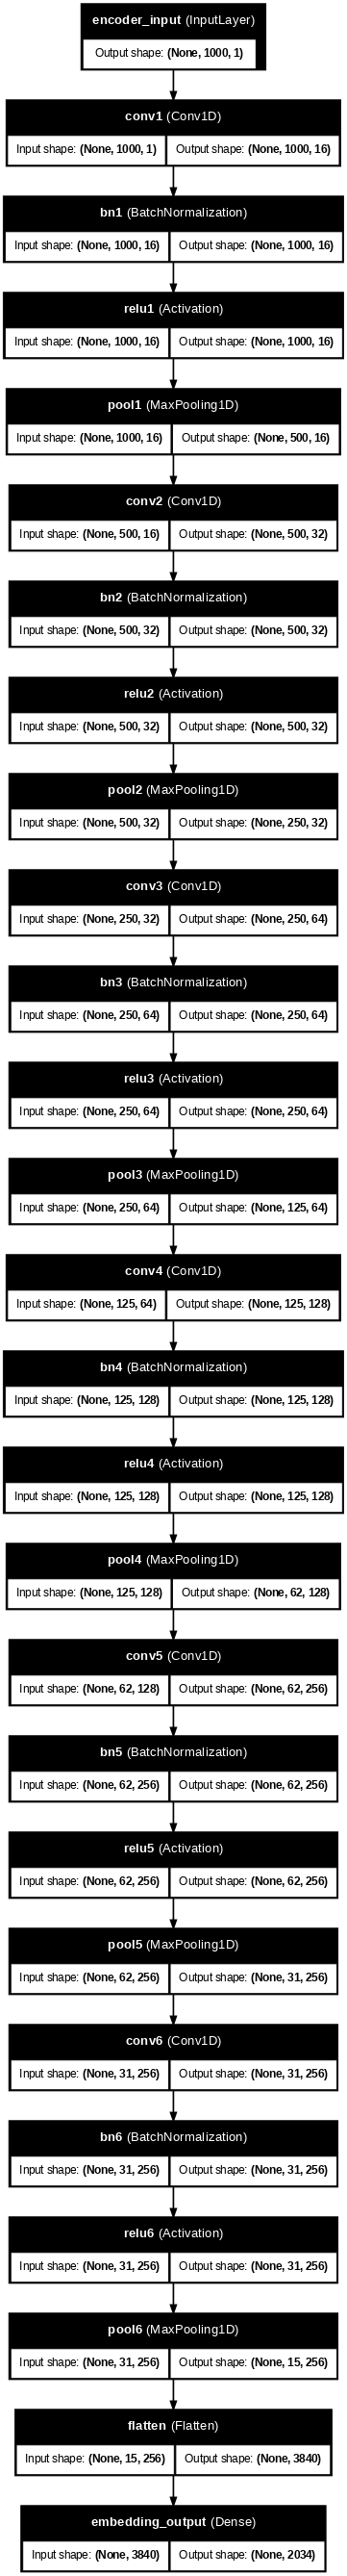

In [56]:

#Plot model ( pydot and graphviz )
tf.keras.utils.plot_model(cnn_encoder_updated, show_shapes=True, show_layer_names=True, dpi=60)

# Split Data into Train and Validation Sets

In [58]:
# =============================================================================
# Code Block 1: Split Data into Train and Validation Sets (Segments)
# Place this cell AFTER your preprocessing cell and BEFORE any generator/network definition.
# =============================================================================

import numpy as np
from sklearn.model_selection import train_test_split
import random # Import random for general seed setting if needed elsewhere
from tqdm.notebook import tqdm # Uncomment if you want progress bars

# Assumes X_data_cnn and source_ids are populated from preprocessing
# Assumes SEGMENT_SAMPLES is defined (e.g., 1000)

print(f"Total segments before split: {len(X_data_cnn)}")
print(f"Total source IDs before split: {len(source_ids)}")

# --- Configuration for Data Split ---
# Use a fixed random state for reproducibility across different runs/frameworks
FIXED_RANDOM_STATE = 42 # You can choose any integer

# Define the proportion of data for validation (e.g., 10% of total segments)
VAL_SIZE_RATIO = 0.10 # 10% for validation
# The rest goes to training (90% in this case)

# --- Perform the Split ---
# We need to stratify by source_id. train_test_split needs integer labels for stratification.
# Create numerical labels for stratification based on source_ids.
# This ensures that the distribution of (Person, Record) pairs is similar in train and val sets.
unique_source_ids_list = sorted(list(set(source_ids)))
source_id_to_int = {src_id: i for i, src_id in enumerate(unique_source_ids_list)}
stratify_labels = np.array([source_id_to_int[src_id] for src_id in source_ids])

# Perform the split
# X_data_cnn is already in the correct shape (N, 1000, 1)
# source_ids is a list of tuples
X_train_cnn, X_val_cnn, source_ids_train, source_ids_val = train_test_split(
    X_data_cnn,          # The data to split
    source_ids,          # Items to split alongside data
    test_size=VAL_SIZE_RATIO, # Proportion for the test set (here used as validation)
    random_state=FIXED_RANDOM_STATE, # Use fixed seed for reproducibility
    stratify=stratify_labels # Stratify to maintain source distribution
)

print(f"\nData split complete (using random_state={FIXED_RANDOM_STATE}):")
print(f"  Training segments: {len(X_train_cnn)}")
print(f"  Validation segments: {len(X_val_cnn)}")
print(f"  Shape of X_train_cnn: {X_train_cnn.shape}")
print(f"  Shape of X_val_cnn: {X_val_cnn.shape}")

# You can optionally check the distribution of source IDs in each set
# from collections import Counter
# print("\nSource ID distribution check:")
# print("Train:", Counter(source_ids_train).most_common(5))
# print("Val:", Counter(source_ids_val).most_common(5))

# Note: The authentication evaluation will later use a *separate* split of the *persons*
# into registered/unregistered, using the *full* X_data_cnn and source_ids,
# but also applying the same FIXED_RANDOM_STATE *before* that person split
# for a fair comparison of evaluation results.

Total segments before split: 6372
Total source IDs before split: 6372

Data split complete (using random_state=42):
  Training segments: 5734
  Validation segments: 638
  Shape of X_train_cnn: (5734, 1000, 1)
  Shape of X_val_cnn: (638, 1000, 1)


# Siamese Framework

In [59]:

# =============================================================================
# Code Block 2: Siamese Generator Setup & Definition (Train & Validation)
# Place this cell AFTER the data splitting cell and BEFORE the network definition.
# =============================================================================

# Assumes:
# - X_train_cnn, source_ids_train are populated from the splitting cell
# - X_val_cnn, source_ids_val are populated from the splitting cell
# - SEGMENT_SAMPLES is defined
# - random is imported and potentially seeded (though the generator itself will use random.choice/sample)

print(f"Setting up Siamese generators...")

# Group segments by their source_id for easier positive pair sampling, separately for train and val
def group_segments_by_source(X_data_input, source_ids_input):
    segments_by_source = {}
    for i, src_id in enumerate(source_ids_input):
        if src_id not in segments_by_source:
            segments_by_source[src_id] = []
        segments_by_source[src_id].append(i) # Store indices of segments
    
    # Filter sources: Need at least 2 segments from a source to form a positive pair
    sources_with_multiple_segments = {src: idx_list for src, idx_list in segments_by_source.items() if len(idx_list) >= 2}
    list_of_valid_sources = list(sources_with_multiple_segments.keys())
    
    return sources_with_multiple_segments, list_of_valid_sources

# Create source mappings for train and validation data
sources_with_multiple_segments_train, list_of_valid_sources_train = group_segments_by_source(X_train_cnn, source_ids_train)
sources_with_multiple_segments_val, list_of_valid_sources_val = group_segments_by_source(X_val_cnn, source_ids_val)


print(f"\nTrain data sources:")
print(f"Number of unique source_ids: {len(group_segments_by_source(X_train_cnn, source_ids_train)[0]) + len([src for src, idx_list in group_segments_by_source(X_train_cnn, source_ids_train)[0].items() if len(idx_list) == 1])}") # Count all unique sources
print(f"Number of sources with >= 2 segments (usable for positive pairs): {len(sources_with_multiple_segments_train)}")

print(f"\nValidation data sources:")
print(f"Number of unique source_ids: {len(group_segments_by_source(X_val_cnn, source_ids_val)[0]) + len([src for src, idx_list in group_segments_by_source(X_val_cnn, source_ids_val)[0].items() if len(idx_list) == 1])}") # Count all unique sources
print(f"Number of sources with >= 2 segments (usable for positive pairs): {len(sources_with_multiple_segments_val)}")


# Define the siamese_pair_generator function (corrected yield structure)
def siamese_pair_generator(X_data_input, sources_map_input, list_of_sources_input, batch_size_input):
    """
    Generates batches of Siamese pairs (segment1, segment2) and labels (1 for positive, 0 for negative).
    Attempts to yield approximately half positive and half negative pairs per batch.
    """
    num_valid_sources = len(list_of_sources_input)
    if num_valid_sources < 2:
         print("Siamese generator requires at least 2 valid sources for negative pairs.")
         # In a real scenario, you might raise an error or handle this.
         # For training, if this happens in validation, it's problematic.
         pass # Let the loop handle potential failures to generate batches

    while True:
        batch_seg1, batch_seg2, batch_labels = [], [], []
        
        # Aim to fill the batch_size
        num_pairs_to_generate = 0
        while num_pairs_to_generate < batch_size_input:
             # Randomly choose whether to make a positive or negative pair attempt
             is_positive = random.random() < 0.5 # 50% chance of positive

             try:
                if is_positive:
                    # Must choose a source with multiple segments
                    if not list_of_sources_input: continue # Should not happen if filtered
                    source_id = random.choice(list_of_sources_input)
                    # Pick two distinct indices from this source
                    # Ensure source_id is in map and has >= 2 segments (should be true due to filtering)
                    if source_id not in sources_map_input or len(sources_map_input[source_id]) < 2:
                        continue # Skip if somehow an invalid source was chosen
                    idx1, idx2 = random.sample(sources_map_input[source_id], 2)
                    label = 1
                else: # Generate Negative Pair
                     # Must choose two *different* sources
                     if num_valid_sources < 2:
                          # print("Cannot generate negative pairs, need at least 2 valid sources.")
                          continue # Cannot make a negative pair if only 0 or 1 source has >=2 segments

                     # Try picking two different sources with at least one segment each
                     source1_id = random.choice(list_of_sources_input)
                     # Ensure the second source is different from the first
                     max_retries = 10 # Prevent infinite loops if data is structured weirdly
                     retry_count = 0
                     source2_id = random.choice(list_of_sources_input)
                     while source1_id == source2_id and num_valid_sources > 1 and retry_count < max_retries:
                         source2_id = random.choice(list_of_sources_input)
                         retry_count += 1
                     
                     if source1_id == source2_id: # Still the same, or only 1 source total
                         # print(f"Warning: Only one valid source ({source1_id}) found for negative pair generation attempt.")
                         continue # Cannot make a valid negative pair


                     # Pick one segment index from each source
                     # Ensure sources are in map and have segments (should be true for sources in list_of_sources_input)
                     if source1_id not in sources_map_input or not sources_map_input[source1_id] or \
                        source2_id not in sources_map_input or not sources_map_input[source2_id]:
                         # print(f"Warning: Chosen sources {source1_id} or {source2_id} not in map or have no segments.")
                         continue # Skip if sources are invalid or have no segments

                     idx1 = random.choice(sources_map_input[source1_id])
                     idx2 = random.choice(sources_map_input[source2_id])
                     label = 0

                # If we successfully generated a pair, add it
                batch_seg1.append(X_data_input[idx1])
                batch_seg2.append(X_data_input[idx2])
                batch_labels.append(label)
                num_pairs_to_generate += 1

             except (ValueError, IndexError) as e:
                  # This might happen if random sampling fails unexpectedly
                  # print(f"Warning: Error generating pair - {e}. Skipping pair attempt.")
                  continue # Skip and try for another pair
             except Exception as e:
                  # Catch other potential errors during pair generation
                  # print(f"Warning: Unexpected error generating pair - {e}. Skipping pair attempt.")
                  continue


        # Ensure we generated a full batch or at least one pair if data is scarce
        if not batch_seg1:
            # print("Warning: Batch generation failed to create any pairs. Retrying batch.")
            continue

        # Convert lists to numpy arrays
        batch_seg1 = np.array(batch_seg1)
        batch_seg2 = np.array(batch_seg2)
        # Make labels float32 as expected by the loss and output_signature
        batch_labels = np.array(batch_labels, dtype=np.float32)

        # Correct Yield: Yield a tuple of inputs, not a list
        yield (batch_seg1, batch_seg2), batch_labels

# --- Create Generator Instances ---
BATCH_SIZE = 32 # Use the batch size you want for training

# Check if enough data exists in train and val sets for generation
if len(list_of_valid_sources_train) >= 2: # Need >= 2 sources with multiple segments in train
    siamese_train_generator_instance = siamese_pair_generator(
        X_train_cnn, sources_with_multiple_segments_train, list_of_valid_sources_train, BATCH_SIZE
    )
    print(f"\nSiamese train generator created with BATCH_SIZE = {BATCH_SIZE}")

    # Test the train generator for one batch
    try:
        ([sample_seg1, sample_seg2]), sample_labels = next(siamese_train_generator_instance)
        print("Successfully generated one batch of Siamese train pairs:")
        print("  Sample Seg1 shape:", sample_seg1.shape)
        print("  Sample Seg2 shape:", sample_seg2.shape)
        print("  Sample Labels shape:", sample_labels.shape)
        # print("  Sample Labels:", sample_labels) # Too much output
    except StopIteration:
        print("ERROR: Siamese train generator did not yield any data.")
        siamese_train_generator_instance = None # Mark as unusable
    except Exception as e:
        print(f"ERROR testing Siamese train generator: {e}")
        siamese_train_generator_instance = None
else:
    print("\nWARNING: Not enough diverse sources in the training data to create Siamese pairs. Training may not be possible.")
    siamese_train_generator_instance = None


# Create validation generator instance
if len(list_of_valid_sources_val) >= 2: # Need >= 2 sources with multiple segments in val
    siamese_val_generator_instance = siamese_pair_generator(
        X_val_cnn, sources_with_multiple_segments_val, list_of_valid_sources_val, BATCH_SIZE # Use the same batch size for validation batches
    )
    print(f"\nSiamese validation generator created with BATCH_SIZE = {BATCH_SIZE}")

    # Test the validation generator for one batch
    try:
        ([sample_seg1, sample_seg2]), sample_labels = next(siamese_val_generator_instance)
        print("Successfully generated one batch of Siamese validation pairs:")
        print("  Sample Seg1 shape:", sample_seg1.shape)
        print("  Sample Seg2 shape:", sample_seg2.shape)
        print("  Sample Labels shape:", sample_labels.shape)
        # print("  Sample Labels:", sample_labels) # Too much output
    except StopIteration:
        print("ERROR: Siamese validation generator did not yield any data.")
        siamese_val_generator_instance = None # Mark as unusable
    except Exception as e:
        print(f"ERROR testing Siamese validation generator: {e}")
        siamese_val_generator_instance = None
else:
     print("\nWARNING: Not enough diverse sources in the validation data to create Siamese pairs. Validation loss monitoring may not be possible.")
     siamese_val_generator_instance = None

Setting up Siamese generators...

Train data sources:
Number of unique source_ids: 310
Number of sources with >= 2 segments (usable for positive pairs): 310

Validation data sources:
Number of unique source_ids: 276
Number of sources with >= 2 segments (usable for positive pairs): 276

Siamese train generator created with BATCH_SIZE = 32
Successfully generated one batch of Siamese train pairs:
  Sample Seg1 shape: (32, 1000, 1)
  Sample Seg2 shape: (32, 1000, 1)
  Sample Labels shape: (32,)

Siamese validation generator created with BATCH_SIZE = 32
Successfully generated one batch of Siamese validation pairs:
  Sample Seg1 shape: (32, 1000, 1)
  Sample Seg2 shape: (32, 1000, 1)
  Sample Labels shape: (32,)


# Define PCC Similarity  and Loss Function

In [60]:
# =============================================================================
# Code Block 3: Siamese Network Model and Loss Definition
# Place this cell AFTER the generator setup and BEFORE the compile/train cell.
# =============================================================================

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model

# Assumes cnn_encoder_updated (the Functional model) is defined from an earlier cell
# Assumes SEGMENT_SAMPLES is defined
# Assume ALPHA_MARGIN is defined (e.g., 0.7 or 0.93) - This is the margin *in the loss function*

# Let's define ALPHA_MARGIN here if it's not already defined globally
if 'ALPHA_MARGIN' not in locals():
    ALPHA_MARGIN = 0.7 # Default margin for the loss - can be tuned

# Reuse the PCC similarity function
def pcc_similarity(tensors):
    emb1, emb2 = tensors
    mean1 = K.mean(emb1, axis=-1, keepdims=True)
    mean2 = K.mean(emb2, axis=-1, keepdims=True)
    centered1 = emb1 - mean1
    centered2 = emb2 - mean2
    covariance = K.sum(centered1 * centered2, axis=-1)
    stddev1 = K.sqrt(K.sum(K.square(centered1), axis=-1))
    stddev2 = K.sqrt(K.sum(K.square(centered2), axis=-1))
    # Add a small epsilon to prevent division by zero
    epsilon = K.epsilon() # Use Keras backend epsilon
    denominator = stddev1 * stddev2 + epsilon
    # Clip the PCC value to the valid range [-1, 1] to prevent NaNs/Infs from extreme values
    pcc = K.clip(covariance / denominator, -1.0, 1.0) 
    return pcc


# --- Define the Siamese Network Model ---
input_seg1 = Input(shape=(SEGMENT_SAMPLES, 1), name="segment1_input")
input_seg2 = Input(shape=(SEGMENT_SAMPLES, 1), name="segment2_input")

# Share the same CNN encoder instance for both inputs
embedding_seg1 = cnn_encoder_updated(input_seg1)
embedding_seg2 = cnn_encoder_updated(input_seg2)

# Calculate the similarity between the embeddings
# Output of this layer is the PCC score for each pair in the batch
similarity_score = Lambda(pcc_similarity, name="pair_similarity")([embedding_seg1, embedding_seg2])

# The Siamese model outputs the similarity score directly
siamese_network = Model(inputs=[input_seg1, input_seg2],
                        outputs=similarity_score,
                        name="siamese_network")

siamese_network.summary()


# --- Define the Siamese Contrastive Loss Function (Similarity-based) ---
# We want:
# For positive pairs (y_true=1): Similarity should be high (close to 1). Loss should be low.
# For negative pairs (y_true=0): Similarity should be low (e.g., below margin). Loss should be low if below margin.

def siamese_contrastive_loss_pcc(y_true, y_pred_similarity):
    """
    Contrastive loss function for Siamese network using PCC as similarity.
    y_true: 1 for positive pair, 0 for negative pair. Expected shape (batch_size,)
    y_pred_similarity: PCC score between the two segments' embeddings. Expected shape (batch_size,)
    ALPHA_MARGIN: The margin for negative pairs (similarity above this is penalized).
    """
    # Ensure shapes are compatible
    y_true = tf.cast(y_true, tf.float32) # Ensure y_true is float32
    y_pred_similarity = tf.cast(y_pred_similarity, tf.float32) # Ensure y_pred_similarity is float32

    # Loss for positive pairs (y_true = 1): Penalize low similarity (high distance = 1 - similarity)
    # We want similarity close to 1, so distance (1-sim) close to 0.
    # Multiply by y_true (which is 1 for positive, 0 for negative)
    pos_loss = y_true * (1.0 - y_pred_similarity)

    # Loss for negative pairs (y_true = 0): Penalize high similarity (above ALPHA_MARGIN)
    # Multiply by (1 - y_true) (which is 0 for positive, 1 for negative)
    # Use K.maximum(0.0, ...) to apply the margin - no penalty if similarity is already below margin
    neg_loss = (1.0 - y_true) * K.maximum(0.0, y_pred_similarity - ALPHA_MARGIN)

    # Total loss is the mean over the batch
    loss = K.mean(pos_loss + neg_loss)
    return loss

print("\nPCC similarity, Siamese Network, and Contrastive Loss function defined.")

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ segment1_input            │ (None, 1000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment2_input            │ (None, 1000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_encoder_fig4          │ (None, 2034)           │      8,292,050 │ segment1_input[0][0],  │
│ (Functional)              │                        │                │ segment2_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pair_similarity (Lambda)  │ (None)                 │              0 │ cnn_encoder_fig4[0][0… │
│                           │                        │                │ cnn_encoder_fig4[1][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,292,050 (31.63 MB)

 Trainable params: 8,290,546 (31.63 MB)

 Non-trainable params: 1,504 (5.88 KB)


PCC similarity, Siamese Network, and Contrastive Loss function defined.


# Compile and Train

Siamese network compiled.

Training config:
  BATCH_SIZE: 32
  EPOCHS: 100
  STEPS_PER_EPOCH_TRAIN: 179
  STEPS_PER_EPOCH_VAL: 19
tf.data.Dataset for training created.
tf.data.Dataset for validation created.

Starting Siamese network training...
Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0693 - val_loss: 0.0475
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0369 - val_loss: 0.0357
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0318 - val_loss: 0.0271
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0305 - val_loss: 0.0306
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0260 - val_loss: 0.0278
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0224 - val_loss: 0.0212
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0241 - val_loss: 0.0263
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0226 - val_loss: 0.0313
Epoch 9/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - l

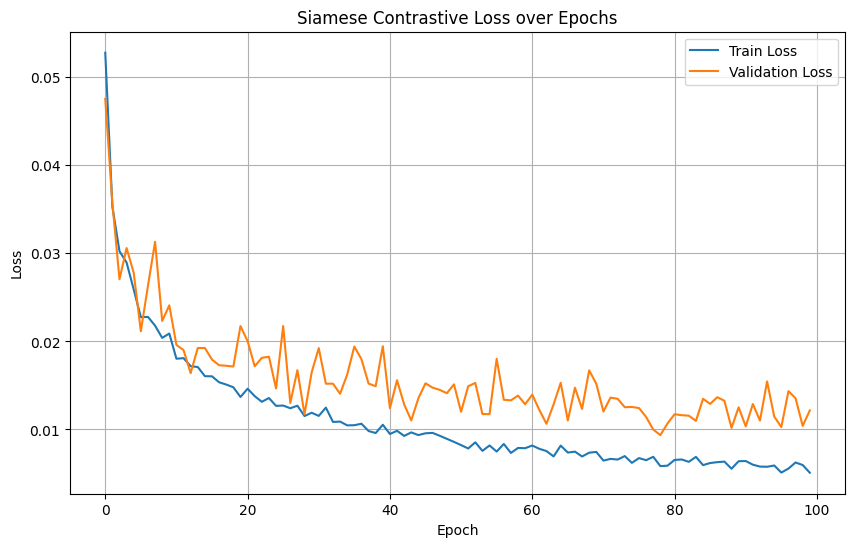

In [62]:
# =============================================================================
# Code Block 4: Compile and Train Siamese Network (with Validation Loss) - FIX APPLIED
# Place this cell AFTER Code Block 3.
# =============================================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assumes:
# - siamese_network (the Keras Model) is defined from Code Block 3
# - siamese_contrastive_loss_pcc (the loss function) is defined from Code Block 3
# - siamese_train_generator_instance is created from Code Block 2
# - siamese_val_generator_instance is created from Code Block 2
# - BATCH_SIZE is defined from Code Block 2
# - SEGMENT_SAMPLES is defined
# - sources_with_multiple_segments_train, list_of_valid_sources_train,
#   sources_with_multiple_segments_val, list_of_valid_sources_val are populated from Code Block 2
# - X_train_cnn, X_val_cnn are populated from Code Block 1

# --- Define/Redefine Optimizer (FIX FOR Unknown variable error) ---
# Define the optimizer *here*, right before compile.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # Define the optimizer instance here


# Compile the Siamese network
siamese_network.compile(optimizer=optimizer, loss=siamese_contrastive_loss_pcc)

print("Siamese network compiled.")

# --- Training Configuration ---
EPOCHS = 100 # Keeping your reduced epochs for now
# Calculate steps per epoch based on training data size and batch size
# Use a heuristic based on total available segments in the train set.
STEPS_PER_EPOCH_TRAIN = max(1, len(X_train_cnn) // BATCH_SIZE)

# Calculate steps per epoch for validation data similarly
STEPS_PER_EPOCH_VAL = max(1, len(X_val_cnn) // BATCH_SIZE)

print(f"\nTraining config:")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  EPOCHS: {EPOCHS}")
print(f"  STEPS_PER_EPOCH_TRAIN: {STEPS_PER_EPOCH_TRAIN}")
print(f"  STEPS_PER_EPOCH_VAL: {STEPS_PER_EPOCH_VAL}")


# --- Create tf.data.Dataset from Generators ---
# Define the output signature matching the generator's yield: ((seg1, seg2), label)
if 'SEGMENT_SAMPLES' not in locals(): SEGMENT_SAMPLES = 1000 # Defensive check

output_sig = (
    (
        tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32) # Label shape
)

# Check if generator instances were successfully created in Code Block 2
# We need the *functions* to create the datasets, not the generator instances directly
# The generator instances were just for testing in Code Block 2
if siamese_train_generator_instance is None: # Check based on whether the *instance* was created successfully
    print("\nCannot start training: Train generator was not successfully created in Code Block 2.")
    tf_train_dataset = None
else:
    # Create tf.data.Dataset for training
    # Pass the generator *function*, not the instance
    py_train_generator_fn = lambda: siamese_pair_generator( # Use the function, not the instance
        X_train_cnn, sources_with_multiple_segments_train, list_of_valid_sources_train, BATCH_SIZE
    )
    tf_train_dataset = tf.data.Dataset.from_generator(
        py_train_generator_fn,
        output_signature=output_sig
    )
    tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)
    print("tf.data.Dataset for training created.")


if siamese_val_generator_instance is None: # Check based on whether the *instance* was created successfully
    print("Validation generator was not successfully created in Code Block 2. Training will proceed without validation.")
    tf_val_dataset = None
else:
     # Create tf.data.Dataset for validation
     # Pass the generator *function*
    py_val_generator_fn = lambda: siamese_pair_generator( # Use the function
        X_val_cnn, sources_with_multiple_segments_val, list_of_valid_sources_val, BATCH_SIZE
    )
    tf_val_dataset = tf.data.Dataset.from_generator(
        py_val_generator_fn,
        output_signature=output_sig
    )
    tf_val_dataset = tf_val_dataset.prefetch(tf.data.AUTOTUNE)
    print("tf.data.Dataset for validation created.")


# --- Fit the Siamese Network ---
if tf_train_dataset is not None:
    print("\nStarting Siamese network training...")
    # Use tqdm as a Keras callback for progress bar during fit if installed
    # callbacks = [tqdm_callback] if 'tqdm_callback' in locals() else None
    callbacks = None # No specific callbacks for now

    history = siamese_network.fit( # Fit the Siamese network
        tf_train_dataset,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
        validation_data=tf_val_dataset, # Include validation dataset
        validation_steps=STEPS_PER_EPOCH_VAL if tf_val_dataset else None, # Use validation steps if val data exists
        callbacks=callbacks, # Pass callbacks list
        verbose=1 # Set to 2 for less verbose output per epoch, 1 for progress bar
    )
    print("\nTraining finished.")

    # Plotting loss history
    if history is not None and 'loss' in history.history:
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Siamese Contrastive Loss over Epochs') # Update plot title
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No 'loss' data in history.history. Cannot plot loss.")

else:
    print("\nTraining skipped because train dataset could not be created.")

# Saving for future


In [64]:
cnn_encoder_updated

<Functional name=cnn_encoder_fig4, built=True>

In [63]:

cnn_encoder_updated.save_weights('trained_cnn_encoder_weights.weights.h5') 
# save the whole model if you prefer, though for inference we just need the encoder
cnn_encoder_updated.save('trained_cnn_encoder_model.keras')
print("Trained CNN encoder weights saved.")

Trained CNN encoder weights saved.


# AUTHENTICATION

In [69]:
# =============================================================================
# Code Block 5: Authentication Evaluation and Score Distribution Plot
# =============================================================================

import matplotlib.pyplot as plt # Ensure matplotlib is imported
import numpy as np # Ensure numpy is imported
import random # Ensure random is imported
# Ensure tf is imported if it's not already global
import tensorflow as tf

# Assumes:
# - X_data_cnn (numpy array of shape (num_total_processed_segments, 1000, 1)) is available
# - source_ids (list of tuples (person_id_str, record_num_str)) is available and its length matches X_data_cnn
# - cnn_encoder_updated (the TRAINED Keras Model from the Siamese training) is available
# - calculate_pcc_numpy (the numpy implementation of PCC) is defined from a previous cell
# - The helper functions load_ecg_id_record, resample_signal, bandpass_filter, normalize_segment are defined (if needed for future steps, though not directly in this block)


print(f"Total processed segments available for authentication evaluation: {len(X_data_cnn)}")
print(f"Total source IDs available: {len(source_ids)}")

# --- Configuration for Authentication & Evaluation ---
NUM_REGISTERED_PERSONS = 60 # The number of distinct persons to register
# For each registered person, how many segments will be used to form their DB entry?
NUM_REG_SEGMENTS_PER_PERSON_DB = 15 # Use the first 10 processed segments from a registered person for their DB entry

# Authentication Threshold: Start with a threshold. We will analyze distributions later.
# Let's use the margin from your training loss as a starting point, or a value near 1.0.
# Based on your previous success with 0.93 achieving low FAR, let's use that.
AUTHENTICATION_THRESHOLD = .75 # Starting threshold for initial evaluation

# --- Ensure Reproducible Person Split for Fair Comparison ---
# THIS IS IMPORTANT for comparing Triplet vs Siamese on the same test set.
# Use the same FIXED_RANDOM_STATE as you used for the train/val segment split (Code Block 1)
if 'FIXED_RANDOM_STATE' not in locals():
    # Define it here if you didn't in Code Block 1, but using the same value is key!
    FIXED_RANDOM_STATE = 42 # Example: ensure this matches your previous split
print(f"\nUsing FIXED_RANDOM_STATE = {FIXED_RANDOM_STATE} for reproducible person split.")
random.seed(FIXED_RANDOM_STATE) # Seed Python's random
np.random.seed(FIXED_RANDOM_STATE) # Seed NumPy's random

# --- 1. Split Persons into Registered and Unregistered Groups ---

# Get unique person IDs from the full processed data
unique_person_ids = sorted(list(set([src[0] for src in source_ids])))
print(f"\nTotal unique persons in processed data: {len(unique_person_ids)}")

if len(unique_person_ids) < NUM_REGISTERED_PERSONS:
    print(f"WARNING: Not enough unique persons ({len(unique_person_ids)}) to register {NUM_REGISTERED_PERSONS}.")
    NUM_REGISTERED_PERSONS = len(unique_person_ids)
    print(f"Adjusted NUM_REGISTERED_PERSONS to {NUM_REGISTERED_PERSONS}.")

# Randomly select registered person IDs using the fixed seed
registered_person_ids = random.sample(unique_person_ids, NUM_REGISTERED_PERSONS)
unregistered_person_ids = [pid for pid in unique_person_ids if pid not in registered_person_ids]

print(f"Registered persons ({len(registered_person_ids)}): {registered_person_ids[:5]}...") # Print a few
print(f"Unregistered persons ({len(unregistered_person_ids)}): {unregistered_person_ids[:5]}...") # Print a few


# Separate segments based on person ID and whether they are for DB or testing
registered_db_segments_indices = [] # Indices in X_data_cnn for registered user DB
test_segments_indices = []          # Indices in X_data_cnn for test set
test_source_ids = []              # source_ids corresponding to test_segments_indices

# Keep track of segments added to DB for each registered person
reg_segments_count = {}

# Iterate through *all* processed segments (6372 in your case)
for i, (segment, src_id) in enumerate(zip(X_data_cnn, source_ids)):
    person_id = src_id[0]

    if person_id in registered_person_ids:
        # This segment is from a registered person
        if person_id not in reg_segments_count:
             reg_segments_count[person_id] = 0

        if reg_segments_count[person_id] < NUM_REG_SEGMENTS_PER_PERSON_DB:
            # Use the first NUM_REG_SEGMENTS_PER_PERSON_DB segments for the DB
            registered_db_segments_indices.append(i)
            reg_segments_count[person_id] += 1
        else:
            # Use subsequent segments from this registered person for testing (True Positives)
            test_segments_indices.append(i)
            test_source_ids.append(src_id) # Store the source ID for ground truth
    else:
        # This segment is from an unregistered person (True Negatives / Impostors)
        test_segments_indices.append(i)
        test_source_ids.append(src_id) # Store the source ID for ground truth


X_reg_db = X_data_cnn[registered_db_segments_indices]
X_test = X_data_cnn[test_segments_indices]

print(f"\nTotal segments for registered user database: {len(registered_db_segments_indices)}")
print(f"Total segments for testing: {len(test_segments_indices)}")
print(f"Shape of X_reg_db: {X_reg_db.shape}")
print(f"Shape of X_test: {X_test.shape}")


# Map source IDs to indices for the registered DB segments
# We need to know which person each DB segment belongs to
reg_db_source_ids = [source_ids[i] for i in registered_db_segments_indices]
# Group DB segments by person ID for easy lookup during authentication
registered_user_db_features = {} # Key: person_id_str, Value: list of feature vectors

# --- 2. Build Registered User Database (Feature Vectors) ---
# Use the TRAINED cnn_encoder_updated from the Siamese training
print("\nBuilding registered user database by running DB segments through the trained encoder...")
# Predict features in batches for efficiency
batch_size_inference = 64 # Use a larger batch size for inference if memory allows

if X_reg_db.size > 0:
    # Note: encoder.predict returns numpy arrays
    db_features = cnn_encoder_updated.predict(X_reg_db, batch_size=batch_size_inference, verbose=1) # Added verbose
else:
    db_features = []
    print("Warning: No segments available for the registered user database.")

# Store features grouped by person ID
for i, src_id in enumerate(reg_db_source_ids):
    person_id = src_id[0]
    if person_id not in registered_user_db_features:
        registered_user_db_features[person_id] = []
    # Store the feature vector (shape (embedding_dim,))
    registered_user_db_features[person_id].append(db_features[i])

print(f"Database built for {len(registered_user_db_features)} registered persons.")

Total processed segments available for authentication evaluation: 6372
Total source IDs available: 6372

Using FIXED_RANDOM_STATE = 42 for reproducible person split.

Total unique persons in processed data: 90
Registered persons (60): ['Person_82', 'Person_15', 'Person_04', 'Person_36', 'Person_32']...
Unregistered persons (30): ['Person_02', 'Person_09', 'Person_11', 'Person_16', 'Person_20']...

Total segments for registered user database: 900
Total segments for testing: 5472
Shape of X_reg_db: (900, 1000, 1)
Shape of X_test: (5472, 1000, 1)

Building registered user database by running DB segments through the trained encoder...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Database built for 60 registered persons.



# --- 3. Implement Authentication Function ---

In [70]:

# This function was defined in a previous step and remains the same.
# Ensure it is defined in a cell run before this one if it's not already.
# It uses calculate_pcc_numpy, which also needs to be defined.

# Example placeholder for the function (remove if you already have it defined)
# def calculate_pcc_numpy(emb1, emb2): ...
# def authenticate_segment(test_segment, registered_db_features, encoder, threshold): ...
# Make sure calculate_pcc_numpy handles single vector vs multiple vectors comparison as shown previously.



# --- 3. Implement Authentication Function ---

# Helper function to calculate PCC for a single test feature vector against multiple stored vectors
# We need the pcc_similarity logic, but applied pairwise and returning maximum.
# The Keras Lambda layer is not directly usable for numpy inference.
# Let's reimplement the core PCC calculation using numpy.
def calculate_pcc_numpy(emb1, emb2):
    """
    Calculates Pearson Correlation Coefficient between two numpy arrays.
    Handles single vectors (1D) or batches (2D).
    """
    # Ensure inputs are numpy arrays and have compatible dimensions
    emb1 = np.asarray(emb1)
    emb2 = np.asarray(emb2)

    if emb1.ndim == 1: emb1 = emb1[np.newaxis, :] # Make 1D -> 2D batch of 1
    if emb2.ndim == 1: emb2 = emb2[np.newaxis, :]

    if emb1.shape[-1] != emb2.shape[-1]:
        raise ValueError("Last dimension of embeddings must match for PCC calculation")
        
    # This numpy implementation mimics the Keras backend logic
    mean1 = np.mean(emb1, axis=-1, keepdims=True)
    mean2 = np.mean(emb2, axis=-1, keepdims=True)
    centered1 = emb1 - mean1
    centered2 = emb2 - mean2
    
    # Covariance: sum over last dimension
    covariance = np.sum(centered1 * centered2, axis=-1)
    
    # Standard deviations: sqrt of sum of squares over last dimension
    stddev1 = np.sqrt(np.sum(np.square(centered1), axis=-1))
    stddev2 = np.sqrt(np.sum(np.square(centered2), axis=-1))
    
    # PCC calculation, add epsilon for numerical stability
    # K.epsilon() is usually 1e-7 in TensorFlow. Use a small number.
    epsilon = 1e-7
    denominator = stddev1 * stddev2 + epsilon
    pcc = covariance / denominator
    
    # If inputs were originally 1D, return a scalar; otherwise, return the batch results
    if emb1.shape[0] == 1 and emb2.shape[0] == 1:
        return pcc[0] # Return scalar if single vectors were compared
    else:
        return pcc # Return batch results


def authenticate_segment(test_segment, registered_db_features, encoder, threshold):
    """
    Authenticates a single test ECG segment against the registered user database.

    Args:
        test_segment (numpy.ndarray): The preprocessed, normalized ECG segment
                                     (shape: (SEGMENT_SAMPLES, 1)).
        registered_db_features (dict): Database {person_id: [feature_vector1, ...], ...}.
                                     Feature vectors are numpy arrays.
        encoder (tf.keras.Model): The trained CNN encoder model.
        threshold (float): The authentication threshold (PCC similarity).

    Returns:
        tuple: (is_authenticated, max_similarity_score, predicted_person_id)
               is_authenticated (bool): True if authentication is successful.
               max_similarity_score (float): The highest PCC score found.
               predicted_person_id (str or None): The ID of the user with the max score,
                                                 or None if no users in DB.
    """
    if not registered_db_features:
        return False, -np.inf, None # No registered users

    # 1. Get feature vector for the test segment
    # Need to add batch dimension for prediction
    test_segment_input = np.expand_dims(test_segment, axis=0) # Shape (1, SEGMENT_SAMPLES, 1)
    test_features = encoder.predict(test_segment_input, verbose=0) # Shape (1, embedding_dim)
    test_features = test_features[0] # Remove batch dim, shape (embedding_dim,)

    # 2. Compare against all stored features in the database
    max_similarity = -np.inf
    predicted_person_id = None

    for person_id, stored_features_list in registered_db_features.items():
        # stored_features_list is a list of numpy arrays, each shape (embedding_dim,)
        
        # Calculate PCC of the test_features (1,) against ALL stored_features for this person (N, embedding_dim)
        # To use calculate_pcc_numpy effectively, stack the stored features for this person
        stacked_stored_features = np.vstack(stored_features_list) # Shape (NumStoredForPerson, embedding_dim)
        
        # Calculate PCC between the single test feature vector and the stacked stored features
        # Need to reshape test_features to (1, embedding_dim) for calculate_pcc_numpy batch processing
        similarities = calculate_pcc_numpy(test_features[np.newaxis, :], stacked_stored_features) # Shape (NumStoredForPerson,)
        
        # Find the maximum similarity score for this person
        max_sim_this_person = np.max(similarities)

        # Update overall max similarity and the corresponding person ID
        if max_sim_this_person > max_similarity:
            max_similarity = max_sim_this_person
            predicted_person_id = person_id

    # 3. Make authentication decision
    is_authenticated = max_similarity > threshold

    return is_authenticated, max_similarity, predicted_person_id

# --- 4. Evaluate the System ---


Evaluating authentication performance on 5472 test segments...

Evaluation Complete.
TP: 2829, TN: 534, FP: 2089, FN: 20

--- Authentication Metrics ---
Configuration:
  Registered Persons: 60
  DB Segments per Registered Person: 15 (approx, using first available)
  Authentication Threshold (PCC): 0.7500
  Total Test Segments: 5472
    True Registered Tests (should be accepted): 2849
    True Unregistered Tests (should be rejected): 2623

Results:
Accuracy: 0.6146
Precision: 0.5752
Recall (TPR): 0.9930
F1 Score: 0.7285
False Acceptance Rate (FAR / FPR): 0.7964
False Rejection Rate (FRR): 0.0070

Plotting score distributions...


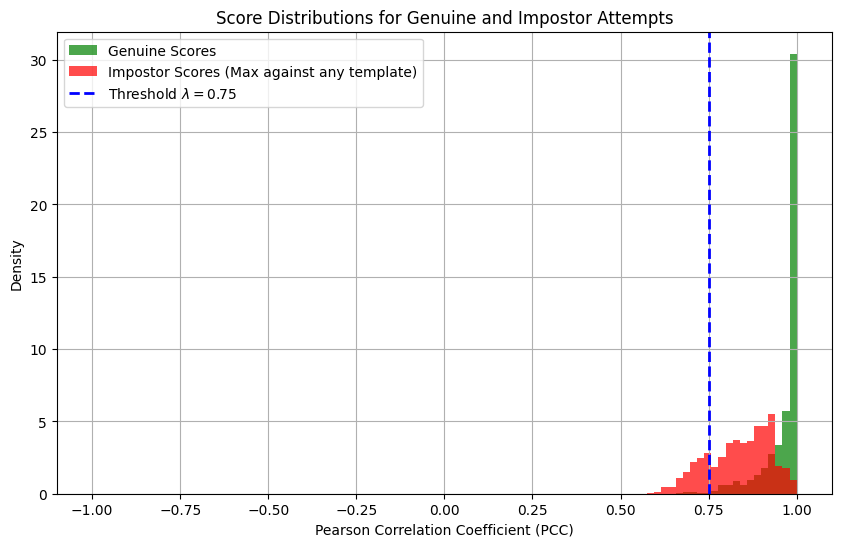

In [73]:


print(f"\nEvaluating authentication performance on {len(X_test)} test segments...")

# --- Data Collection for Plotting ---
# Initialize lists to store scores based on ground truth
genuine_scores = []
impostor_scores = []

# Metrics (keep these as well)
TP, TN, FP, FN = 0, 0, 0, 0

# Check if there are test segments and a database to evaluate against
if len(X_test) > 0 and len(registered_user_db_features) > 0:
    # Iterate through the test segments
    # Use tqdm for a progress bar if you have it installed (pip install tqdm)
    # from tqdm.notebook import tqdm
    # for i, test_segment in enumerate(tqdm(X_test, desc="Authenticating test segments")):

    for i, test_segment in enumerate(X_test):
        true_source_id = test_source_ids[i]
        true_person_id = true_source_id[0]

        # Determine the ground truth: Is this segment from a registered user?
        is_true_registered = true_person_id in registered_person_ids

        # Perform authentication using the developed function
        # This function already returns max_similarity_score
        # Ensure authenticate_segment function is defined before this cell
        is_authenticated, max_sim_score, predicted_person_id = authenticate_segment(
            test_segment, registered_user_db_features, cnn_encoder_updated, AUTHENTICATION_THRESHOLD
        )

        # --- Store the score for plotting ---
        if is_true_registered:
            genuine_scores.append(max_sim_score)
            # Update metrics based on authentication decision
            if is_authenticated:
                TP += 1
            else:
                FN += 1
        else: # Segment is from an unregistered user (impostor)
            impostor_scores.append(max_sim_score)
            # Update metrics based on authentication decision
            if is_authenticated:
                FP += 1
            else:
                TN += 1

    # After the loop, genuine_scores and impostor_scores lists are populated

    print("\nEvaluation Complete.")
    print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")


    # --- Calculate final metrics ---
    total_tests = TP + TN + FP + FN
    accuracy = (TP + TN) / total_tests if total_tests > 0 else 0

    # Check for division by zero in precision, recall, FAR, FRR
    # Precision = TP / (TP + FP)  (Out of accepted users, how many were correct?)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    # Recall (TPR) = TP / (TP + FN)     (Out of true registered users, how many were accepted?)
    true_registered_count = TP + FN
    recall_tpr = TP / true_registered_count if true_registered_count > 0 else 0
    # FPR = FP / (TN + FP)        (Out of true unregistered users, how many were falsely accepted?) - False Acceptance Rate
    true_unregistered_count = TN + FP
    fpr_far = FP / true_unregistered_count if true_unregistered_count > 0 else 0
    # FRR = FN / (TP + FN)        (Out of true registered users, how many were falsely rejected?) - False Rejection Rate
    frr = FN / true_registered_count if true_registered_count > 0 else 0 # Note: recall_tpr = 1 - frr

    # F1 Score (Harmonic mean of Precision and Recall)
    f1_score = 2 * (precision * recall_tpr) / (precision + recall_tpr) if (precision + recall_tpr) > 0 else 0


    print("\n--- Authentication Metrics ---")
    print(f"Configuration:")
    print(f"  Registered Persons: {NUM_REGISTERED_PERSONS}")
    print(f"  DB Segments per Registered Person: {NUM_REG_SEGMENTS_PER_PERSON_DB} (approx, using first available)")
    print(f"  Authentication Threshold (PCC): {AUTHENTICATION_THRESHOLD:.4f}")
    print(f"  Total Test Segments: {total_tests}")
    print(f"    True Registered Tests (should be accepted): {true_registered_count}")
    print(f"    True Unregistered Tests (should be rejected): {true_unregistered_count}")


    print(f"\nResults:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (TPR): {recall_tpr:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"False Acceptance Rate (FAR / FPR): {fpr_far:.4f}")
    print(f"False Rejection Rate (FRR): {frr:.4f}")


    # --- Plotting Score Distributions ---
    print("\nPlotting score distributions...")

    if genuine_scores and impostor_scores: # Check if we collected any scores
        plt.figure(figsize=(10, 6))

        # Use common bins for both histograms to align them
        # PCC range is -1 to 1. Let's create bins across this range.
        bins = np.linspace(-1.0, 1.0, 100) # 100 bins from -1 to 1

        # Plot Genuine Scores histogram
        # density=True ensures the area sums to 1, allowing comparison of shapes
        plt.hist(genuine_scores, bins=bins, color='green', alpha=0.7, density=True, label='Genuine Scores')

        # Plot Impostor Scores histogram
        plt.hist(impostor_scores, bins=bins, color='red', alpha=0.7, density=True, label='Impostor Scores (Max against any template)')

        # Add the authentication threshold line
        plt.axvline(x=AUTHENTICATION_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold $\lambda={AUTHENTICATION_THRESHOLD:.2f}$')

        plt.title('Score Distributions for Genuine and Impostor Attempts')
        plt.xlabel('Pearson Correlation Coefficient (PCC)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Not enough genuine or impostor scores collected to plot distribution.")

else:
    print("\nAuthentication evaluation skipped because there are no test segments or no registered users.")

# Plotting FAR vs. FRR Curve for Threshold Tuning

Analyzing FAR vs. FRR trade-off across different thresholds...
FAR/FRR calculation complete.


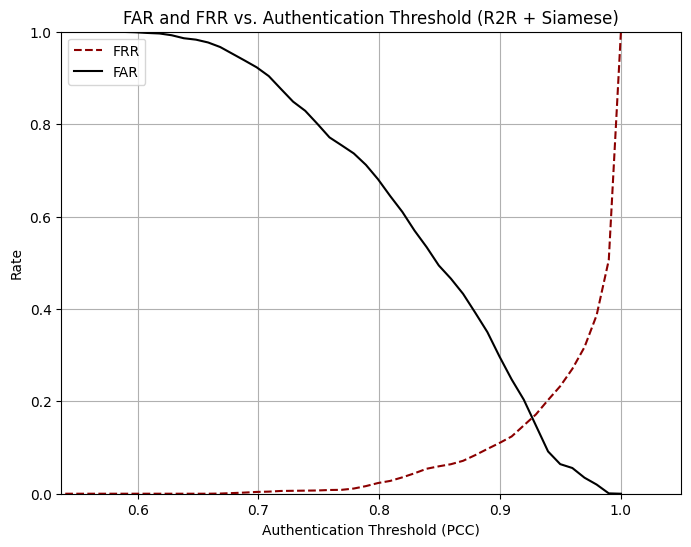


Estimated Equal Error Rate (EER):
  Threshold: 0.9296
  Rate (approx. FAR=FRR): 0.1596

Performance at Target FAR = 1.00%:
  Threshold: 1.0000
  Corresponding FRR: 1.0000
  Actual FAR at this threshold: 0.0000


In [77]:
# =============================================================================
# Code Block 6: Plotting FAR vs. FRR Curve for Threshold Tuning - FIX APPLIED
# Place this cell AFTER the Authentication Evaluation cell (Code Block 5).
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Assumes:
# - genuine_scores (list or numpy array of scores from genuine attempts) is populated
# - impostor_scores (list or numpy array of scores from impostor attempts) is populated

print("Analyzing FAR vs. FRR trade-off across different thresholds...")

# Convert lists to numpy arrays for easier processing (already done in original code)
# Make sure genuine_scores and impostor_scores are indeed numpy arrays at this point
# If they are lists, this check would work: if not genuine_scores or not impostor_scores:
# But since they are numpy arrays later, we need a numpy-compatible check here.
# A simple check for if the list conversion was successful and they aren't empty arrays:
if not isinstance(genuine_scores, np.ndarray) or genuine_scores.size == 0 or \
   not isinstance(impostor_scores, np.ndarray) or impostor_scores.size == 0:
    print("Genuine or Impostor scores are not available as non-empty numpy arrays. Cannot plot FAR/FRR curve.")
else:
    # Define a range of thresholds to test
    # It's good to cover the full range of possible PCC scores (-1 to 1)
    # or at least the range where scores were actually observed.
    # Let's use linspace for equally spaced thresholds.
    # You can adjust the number of steps (e.g., 1000 steps for finer granularity)
    threshold_range = np.linspace(-1.0, 1.0, 200) # Test 200 thresholds from -1 to 1

    # Initialize lists to store FAR and FRR for each threshold
    far_values = []
    frr_values = []
    tpr_values = [] # TPR = 1 - FRR, often plotted too

    # Get total counts for calculating rates
    total_genuine = len(genuine_scores)
    total_impostors = len(impostor_scores)

    # Iterate through each threshold
    # Use tqdm for a progress bar if installed:
    # from tqdm.notebook import tqdm
    # for threshold in tqdm(threshold_range, desc="Evaluating Thresholds"):

    for threshold in threshold_range:
        # Calculate False Rejections (FN) and True Positives (TP) for genuine scores
        # A genuine score is rejected if it's < threshold
        fn_count = np.sum(genuine_scores < threshold)
        tp_count = np.sum(genuine_scores >= threshold)

        # Calculate False Acceptances (FP) and True Negatives (TN) for impostor scores
        # An impostor score is accepted if it's >= threshold
        fp_count = np.sum(impostor_scores >= threshold)
        tn_count = np.sum(impostor_scores < threshold)

        # Calculate FRR and FAR for this threshold
        # Add checks for total_genuine/total_impostors being zero to avoid division errors
        frr = fn_count / total_genuine if total_genuine > 0 else (1.0 if fn_count > 0 else 0.0) # If no genuine, FRR is 1 if any rejected, 0 otherwise
        far = fp_count / total_impostors if total_impostors > 0 else (1.0 if fp_count > 0 else 0.0) # If no impostors, FAR is 1 if any accepted, 0 otherwise
        tpr = tp_count / total_genuine if total_genuine > 0 else (0.0 if tp_count == 0 else 1.0) # Calculate TPR

        # Store the results
        frr_values.append(frr)
        far_values.append(far)
        tpr_values.append(tpr)

    print("FAR/FRR calculation complete.")

    # --- Plot the FAR vs. FRR curve ---
    plt.figure(figsize=(8, 6))

    # Plot FRR
    plt.plot(threshold_range, frr_values, linestyle='--', color='darkred', label='FRR')

    # Plot FAR
    plt.plot(threshold_range, far_values, linestyle='-', color='black', label='FAR')

    # Optional: Plot TPR
    # plt.plot(threshold_range, tpr_values, linestyle='-', color='darkgreen', label='TPR (Recall)')


    plt.title('FAR and FRR vs. Authentication Threshold (R2R + Siamese)') # Update title
    plt.xlabel('Authentication Threshold (PCC)')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    # Set x-axis limits to focus on relevant range based on your scores.
    # Look at the previous score distribution plot to pick sensible min/max x-values.
    # Or use min/max of the scores: min(np.min(genuine_scores), np.min(impostor_scores)) to max(np.max(genuine_scores), np.max(impostor_scores))
    plt.xlim([np.min(impostor_scores)-0.05, np.max(genuine_scores)+0.05]) # Auto-set limits based on actual scores
    plt.ylim([0.0, 1.0]) # Y-axis is rates, 0 to 1

    # Add vertical lines for specific points of interest (optional)
    # E.g., your last tested threshold
    # plt.axvline(x=AUTHENTICATION_THRESHOLD, color='gray', linestyle=':', linewidth=1, label=f'Eval Thresh={AUTHENTICATION_THRESHOLD:.2f}')


    plt.show()

    # --- Find Equal Error Rate (EER) ---
    # EER is where FAR == FRR. Find the threshold where the two curves intersect.
    # This can be approximated by finding where the absolute difference is minimum.
    # Need to make sure genuine_scores and impostor_scores have overlap in scores.
    if np.max(impostor_scores) < np.min(genuine_scores):
        print("\nGenuine and Impostor score distributions do not overlap. Perfect separation is possible.")
        # EER is effectively 0, threshold is anywhere in the gap
        eer_threshold = np.mean([np.max(impostor_scores), np.min(genuine_scores)])
        eer_rate = 0.0
        print(f"  Threshold: {eer_threshold:.4f} (any threshold in the gap works)")
        print(f"  Rate (FAR=FRR): {eer_rate:.4f}")

    elif np.max(far_values) < np.min(frr_values):
         print("\nFAR curve is entirely below FRR curve. EER might be outside threshold range or near 0/1.")
         # Can still try to find the minimum difference within the range
         diffs = np.abs(np.array(far_values) - np.array(frr_values))
         eer_threshold_index = np.argmin(diffs)
         eer_threshold = threshold_range[eer_threshold_index]
         eer_rate = (far_values[eer_threshold_index] + frr_values[eer_threshold_index]) / 2
         print(f"\nEstimated EER (within tested range):")
         print(f"  Threshold: {eer_threshold:.4f}")
         print(f"  Rate (approx. FAR=FRR): {eer_rate:.4f}")

    else: # There is an intersection or overlap
        diffs = np.abs(np.array(far_values) - np.array(frr_values))
        eer_threshold_index = np.argmin(diffs)
        eer_threshold = threshold_range[eer_threshold_index]
        # Average the FAR and FRR at the index where the difference is minimum
        # Note: this is an approximation of EER, the true EER threshold is where they *cross*
        eer_rate = (far_values[eer_threshold_index] + frr_values[eer_threshold_index]) / 2

        print(f"\nEstimated Equal Error Rate (EER):")
        print(f"  Threshold: {eer_threshold:.4f}")
        print(f"  Rate (approx. FAR=FRR): {eer_rate:.4f}")


    # You can also print FAR and FRR at specific thresholds if needed
    # For example, to find the threshold for a target FAR of 1% (0.01):
    target_far = 0.01
    # Find the index of the threshold that results in the closest FAR to the target
    # Find thresholds where FAR <= target_far
    eligible_indices = np.where(np.array(far_values) <= target_far)[0]

    if len(eligible_indices) > 0:
         # Choose the largest threshold that keeps FAR <= target_far (this minimizes FRR)
         threshold_for_target_far_index = eligible_indices[-1]
         threshold_for_target_far = threshold_range[threshold_for_target_far_index]
         frr_at_target_far = frr_values[threshold_for_target_far_index]
         actual_far_at_target_threshold = far_values[threshold_for_target_far_index]


         print(f"\nPerformance at Target FAR = {target_far*100:.2f}%:")
         print(f"  Threshold: {threshold_for_target_far:.4f}")
         print(f"  Corresponding FRR: {frr_at_target_far:.4f}")
         print(f"  Actual FAR at this threshold: {actual_far_at_target_threshold:.4f}") # Report actual FAR

    else:
         print(f"\nTarget FAR = {target_far*100:.2f}% not achieved within the tested threshold range ({np.min(far_values)*100:.2f}% min FAR).")

# found best authentication threshold=0.9296

# UPDATED AUTHENTICATION AND EVAL


--- Re-running Authentication Evaluation at EER Threshold ---
Total processed segments available: 6372

Using FIXED_RANDOM_STATE = 42 for reproducible person split.
Evaluating at Authentication Threshold (PCC): 0.9296
  Total segments for registered user database: 900
  Total segments for testing: 5472

  Building registered user database by running DB segments through the trained encoder...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
  Database built for 60 registered persons.

  Evaluating authentication performance on 5472 test segments...

  Evaluation Complete.
  TP: 2361, TN: 2236, FP: 387, FN: 488

--- Authentication Metrics at EER Threshold ---
Configuration:
  Registered Persons: 60
  DB Segments per Registered Person: 15
  Authentication Threshold (PCC): 0.9296
  Total Test Segments: 5472
    True Registered Tests (should be accepted): 2849
    True Unregistered Tests (should be rejected): 2623

Results:
Accuracy: 0.8401
Precision: 0.8592
Recall (TPR): 0.8287
F1 Score: 0.8437
Fa

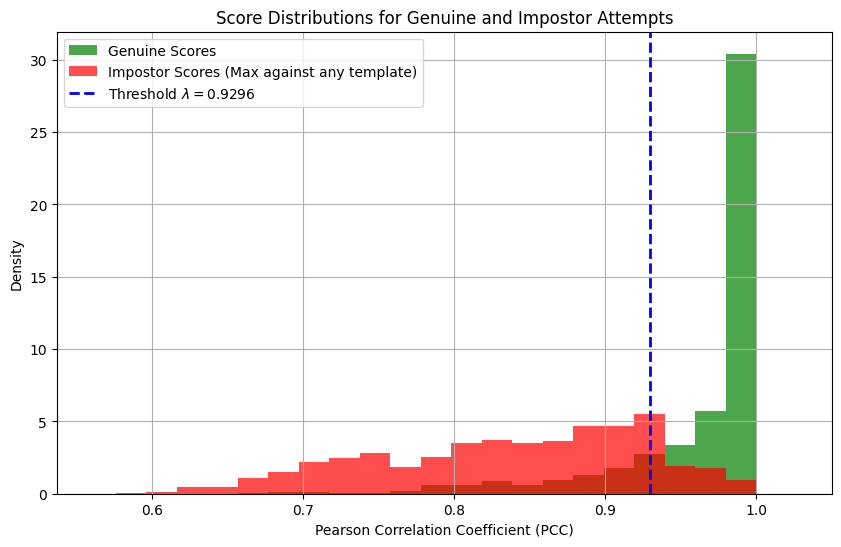

In [78]:
# =============================================================================
# Code Block X: Re-run Authentication Evaluation with EER Threshold
# Place this cell AFTER Code Block 5.
# This block re-evaluates performance using the trained encoder
# and the SAME registered/unregistered split as the previous run,
# but with the specific EER threshold.
# =============================================================================

import matplotlib.pyplot as plt # Ensure matplotlib is imported (needed if plotting scores)
import numpy as np # Ensure numpy is imported
import random # Ensure random is imported
# Ensure tf is imported if it's not already global
import tensorflow as tf

# Assumes:
# - X_data_cnn (numpy array of shape (num_total_processed_segments, 1000, 1)) is available
# - source_ids (list of tuples (person_id_str, record_num_str)) is available and its length matches X_data_cnn
# - cnn_encoder_updated (the TRAINED Keras Model) is available from training
# - calculate_pcc_numpy (the numpy implementation of PCC) is defined from a previous cell
# - authenticate_segment (the function to perform authentication) is defined from a previous cell
# - FIXED_RANDOM_STATE is defined and used for the previous person split (set to 42 in our example)
# - NUM_REGISTERED_PERSONS and NUM_REG_SEGMENTS_PER_PERSON_DB are defined (60 and 15 in your last run)


print(f"\n--- Re-running Authentication Evaluation at EER Threshold ---")
print(f"Total processed segments available: {len(X_data_cnn)}")

# --- Configuration for this Evaluation Run ---
# Use the SAME configuration as your previous evaluation run (Code Block 5)
# EXCEPT for the threshold.
if 'NUM_REGISTERED_PERSONS' not in locals(): NUM_REGISTERED_PERSONS = 60 # Default based on your run
if 'NUM_REG_SEGMENTS_PER_PERSON_DB' not in locals(): NUM_REG_SEGMENTS_PER_PERSON_DB = 15 # Default based on your run
if 'FIXED_RANDOM_STATE' not in locals(): FIXED_RANDOM_STATE = 42 # MUST MATCH previous run

# --- Set the NEW Authentication Threshold (the estimated EER threshold) ---
AUTHENTICATION_THRESHOLD = 0.9296 # Use the estimated EER threshold from the plot

print(f"\nUsing FIXED_RANDOM_STATE = {FIXED_RANDOM_STATE} for reproducible person split.")
print(f"Evaluating at Authentication Threshold (PCC): {AUTHENTICATION_THRESHOLD:.4f}")


# --- 1. Split Persons into Registered and Unregistered Groups (REPEATING THE SPLIT WITH SAME SEED) ---
# This guarantees the same persons are selected as registered/unregistered as in the previous evaluation run.

random.seed(FIXED_RANDOM_STATE) # Seed Python's random
np.random.seed(FIXED_RANDOM_STATE) # Seed NumPy's random

# Get unique person IDs from the full processed data
unique_person_ids = sorted(list(set([src[0] for src in source_ids])))
# print(f"\nTotal unique persons in processed data: {len(unique_person_ids)}") # Already printed

if len(unique_person_ids) < NUM_REGISTERED_PERSONS:
    print(f"WARNING: Not enough unique persons ({len(unique_person_ids)}) to register {NUM_REGISTERED_PERSONS}.")
    NUM_REGISTERED_PERSONS_THIS_RUN = len(unique_person_ids)
    print(f"Adjusted NUM_REGISTERED_PERSONS for this run to {NUM_REGISTERED_PERSONS_THIS_RUN}.")
else:
    NUM_REGISTERED_PERSONS_THIS_RUN = NUM_REGISTERED_PERSONS


# Randomly select registered person IDs using the fixed seed
registered_person_ids_this_run = random.sample(unique_person_ids, NUM_REGISTERED_PERSONS_THIS_RUN)
unregistered_person_ids_this_run = [pid for pid in unique_person_ids if pid not in registered_person_ids_this_run]

# print(f"Registered persons ({len(registered_person_ids_this_run)}): {registered_person_ids_this_run[:5]}...") # Already printed
# print(f"Unregistered persons ({len(unregistered_person_ids_this_run)}): {unregistered_person_ids_this_run[:5]}...") # Already printed


# Separate segments based on person ID and whether they are for DB or testing (REPEATING THE SEGMENT SPLIT)
registered_db_segments_indices_this_run = [] # Indices in X_data_cnn for registered user DB
test_segments_indices_this_run = []          # Indices in X_data_cnn for test set
test_source_ids_this_run = []              # source_ids corresponding to test_segments_indices

# Keep track of segments added to DB for each registered person
reg_segments_count_this_run = {}

# Iterate through *all* processed segments (6372 in your case)
for i, (segment, src_id) in enumerate(zip(X_data_cnn, source_ids)):
    person_id = src_id[0]

    if person_id in registered_person_ids_this_run:
        # This segment is from a registered person
        if person_id not in reg_segments_count_this_run:
             reg_segments_count_this_run[person_id] = 0

        if reg_segments_count_this_run[person_id] < NUM_REG_SEGMENTS_PER_PERSON_DB:
            # Use the first NUM_REG_SEGMENTS_PER_PERSON_DB segments for the DB
            registered_db_segments_indices_this_run.append(i)
            reg_segments_count_this_run[person_id] += 1
        else:
            # Use subsequent segments from this registered person for testing (True Positives)
            test_segments_indices_this_run.append(i)
            test_source_ids_this_run.append(src_id) # Store the source ID for ground truth
    else:
        # This segment is from an unregistered person (True Negatives / Impostors)
        test_segments_indices_this_run.append(i)
        test_source_ids_this_run.append(src_id) # Store the source ID for ground truth


X_reg_db_this_run = X_data_cnn[registered_db_segments_indices_this_run]
X_test_this_run = X_data_cnn[test_segments_indices_this_run]

print(f"  Total segments for registered user database: {len(registered_db_segments_indices_this_run)}")
print(f"  Total segments for testing: {len(test_segments_indices_this_run)}")
# print(f"  Shape of X_reg_db: {X_reg_db_this_run.shape}") # Already printed
# print(f"  Shape of X_test: {X_test_this_run.shape}") # Already printed


# Map source IDs to indices for the registered DB segments
# We need to know which person each DB segment belongs to
reg_db_source_ids_this_run = [source_ids[i] for i in registered_db_segments_indices_this_run]
# Group DB segments by person ID for easy lookup during authentication
registered_user_db_features_this_run = {} # Key: person_id_str, Value: list of feature vectors

# --- 2. Build Registered User Database (Feature Vectors) (REPEATING DB BUILDING) ---
# Use the TRAINED cnn_encoder_updated from the Siamese training
print("\n  Building registered user database by running DB segments through the trained encoder...")
# Predict features in batches for efficiency
batch_size_inference = 64 # Use a larger batch size for inference if memory allows

if X_reg_db_this_run.size > 0:
    # Note: encoder.predict returns numpy arrays
    db_features_this_run = cnn_encoder_updated.predict(X_reg_db_this_run, batch_size=batch_size_inference, verbose=1)
else:
    db_features_this_run = []
    print("Warning: No segments available for the registered user database in this run.")

# Store features grouped by person ID
for i, src_id in enumerate(reg_db_source_ids_this_run):
    person_id = src_id[0]
    if person_id not in registered_user_db_features_this_run:
        registered_user_db_features_this_run[person_id] = []
    # Store the feature vector (shape (embedding_dim,))
    registered_user_db_features_this_run[person_id].append(db_features_this_run[i])

print(f"  Database built for {len(registered_user_db_features_this_run)} registered persons.")


# --- 3. Implement Authentication Function ---
# This function was defined in a previous step and remains the same.
# Ensure it is defined in a cell run before this one if it's not already.
# It uses calculate_pcc_numpy, which also needs to be defined.
# We will call the existing authenticate_segment function.


# --- 4. Evaluate the System (REPEATING EVALUATION WITH NEW THRESHOLD) ---

print(f"\n  Evaluating authentication performance on {len(X_test_this_run)} test segments...")

# --- Data Collection for Plotting (Still collect scores, but main goal is metrics) ---
# Initialize lists to store scores based on ground truth
genuine_scores_this_run = [] # Use new variable names for clarity
impostor_scores_this_run = []

# Metrics
TP, TN, FP, FN = 0, 0, 0, 0

# Check if there are test segments and a database to evaluate against
if len(X_test_this_run) > 0 and len(registered_user_db_features_this_run) > 0:
    # Iterate through the test segments
    # Use tqdm for a progress bar if you have it installed (pip install tqdm)
    # from tqdm.notebook import tqdm
    # for i, test_segment in enumerate(tqdm(X_test_this_run, desc="Authenticating test segments")):

    for i, test_segment in enumerate(X_test_this_run):
        true_source_id = test_source_ids_this_run[i]
        true_person_id = true_source_id[0]

        # Determine the ground truth: Is this segment from a registered user?
        is_true_registered = true_person_id in registered_person_ids_this_run

        # Perform authentication using the *existing* authenticate_segment function
        # Pass the data and features for *this run*
        is_authenticated, max_sim_score, predicted_person_id = authenticate_segment(
            test_segment, registered_user_db_features_this_run, cnn_encoder_updated, AUTHENTICATION_THRESHOLD # Use the NEW threshold
        )

        # --- Store the score ---
        if is_true_registered:
            genuine_scores_this_run.append(max_sim_score)
            # Update metrics based on authentication decision
            if is_authenticated:
                TP += 1
            else:
                FN += 1
        else: # Segment is from an unregistered user (impostor)
            impostor_scores_this_run.append(max_sim_score)
            # Update metrics based on authentication decision
            if is_authenticated:
                FP += 1
            else:
                TN += 1

    # After the loop, genuine_scores_this_run and impostor_scores_this_run lists are populated

    print("\n  Evaluation Complete.")
    print(f"  TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")


    # --- Calculate final metrics ---
    total_tests = TP + TN + FP + FN
    accuracy = (TP + TN) / total_tests if total_tests > 0 else 0

    # Check for division by zero
    true_registered_count = TP + FN
    true_unregistered_count = TN + FP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall_tpr = TP / true_registered_count if true_registered_count > 0 else 0
    fpr_far = FP / true_unregistered_count if true_unregistered_count > 0 else 0
    frr = FN / true_registered_count if true_registered_count > 0 else 0

    f1_score = 2 * (precision * recall_tpr) / (precision + recall_tpr) if (precision + recall_tpr) > 0 else 0


    print("\n--- Authentication Metrics at EER Threshold ---")
    print(f"Configuration:")
    print(f"  Registered Persons: {NUM_REGISTERED_PERSONS_THIS_RUN}")
    print(f"  DB Segments per Registered Person: {NUM_REG_SEGMENTS_PER_PERSON_DB}")
    print(f"  Authentication Threshold (PCC): {AUTHENTICATION_THRESHOLD:.4f}")
    print(f"  Total Test Segments: {total_tests}")
    print(f"    True Registered Tests (should be accepted): {true_registered_count}")
    print(f"    True Unregistered Tests (should be rejected): {true_unregistered_count}")


    print(f"\nResults:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (TPR): {recall_tpr:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"False Acceptance Rate (FAR / FPR): {fpr_far:.4f}")
    print(f"False Rejection Rate (FRR): {frr:.4f}")

    # Note: At EER, FAR and FRR should be approximately equal. The calculated FAR and FRR
    # at the estimated EER threshold might not be *exactly* equal due to the finite
    # number of test samples and the discrete nature of thresholds tested in the plot.
    # Compare these values to the EER rate (0.1596) you calculated from the plot.


    # --- Optional: Plot Score Distributions for THIS run's scores and threshold ---
    # You can uncomment this section if you want to see the distribution plot
    # with the 0.9296 threshold overlaid on the scores from this specific run.
    # (You already have the full FAR/FRR curve plot, so this is less critical now).
    print("\nPlotting score distributions for this threshold...")
    
    if genuine_scores_this_run and impostor_scores_this_run:
        plt.figure(figsize=(10, 6))
        bins = np.linspace(-1.0, 1.0, 100)
        plt.hist(genuine_scores_this_run, bins=bins, color='green', alpha=0.7, density=True, label='Genuine Scores')
        plt.hist(impostor_scores_this_run, bins=bins, color='red', alpha=0.7, density=True, label='Impostor Scores (Max against any template)')
        plt.axvline(x=AUTHENTICATION_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold $\lambda={AUTHENTICATION_THRESHOLD:.4f}$')
        plt.title('Score Distributions for Genuine and Impostor Attempts')
        plt.xlabel('Pearson Correlation Coefficient (PCC)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.xlim([np.min(impostor_scores_this_run)-0.05, np.max(genuine_scores_this_run)+0.05])
        plt.ylim([0.0, plt.ylim()[1]]) # Keep y-axis limit flexible
        plt.show()
    else:
        print("Not enough genuine or impostor scores collected to plot distribution for this threshold.")

else:
    print("\nAuthentication evaluation skipped. Check if test data or registered user features were created successfully.")

#

# HY.P.TUNING OF LAMBDA/ALPHA MARGIN

# 

# Code Block A: Define Custom Siamese Contrastive Loss Class

In [80]:


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
# Assume cnn_encoder_updated is defined later in the tuning loop
# Assume SEGMENT_SAMPLES is defined

# Reuse the PCC similarity function (no change needed here)
def pcc_similarity(tensors):
    emb1, emb2 = tensors
    mean1 = K.mean(emb1, axis=-1, keepdims=True)
    mean2 = K.mean(emb2, axis=-1, keepdims=True)
    centered1 = emb1 - mean1
    centered2 = emb2 - mean2
    covariance = K.sum(centered1 * centered2, axis=-1)
    stddev1 = K.sqrt(K.sum(K.square(centered1), axis=-1))
    stddev2 = K.sqrt(K.sum(K.square(centered2), axis=-1))
    epsilon = K.epsilon()
    pcc = K.clip(covariance / (stddev1 * stddev2 + epsilon), -1.0, 1.0)
    return pcc


# --- Define Custom Siamese Contrastive Loss Class ---
# This allows us to pass the margin during instantiation
class SiameseContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=0.7, name="siamese_contrastive_loss"):
        super().__init__(name=name)
        if not isinstance(margin, (int, float)) or margin < -1.0 or margin > 1.0:
             raise ValueError(f"Margin must be a number between -1.0 and 1.0, got {margin}")
        self.margin = float(margin) # Ensure margin is float

    def call(self, y_true, y_pred_similarity):
        """
        Contrastive loss function for Siamese network using PCC as similarity.
        y_true: 1 for positive pair, 0 for negative pair. Expected shape (batch_size,)
        y_pred_similarity: PCC score between the two segments' embeddings. Expected shape (batch_size,)
        self.margin: The margin for negative pairs (similarity above this is penalized).
        """
        # Ensure shapes and dtypes are compatible
        y_true = tf.cast(y_true, tf.float32)
        y_pred_similarity = tf.cast(y_pred_similarity, tf.float32)

        # Loss for positive pairs (y_true = 1): Penalize low similarity (high distance = 1 - similarity)
        # We want similarity close to 1, so distance (1-sim) close to 0.
        pos_loss = y_true * (1.0 - y_pred_similarity)

        # Loss for negative pairs (y_true = 0): Penalize high similarity (above self.margin)
        # Use K.maximum(0.0, ...) to apply the margin - no penalty if similarity is already below margin
        neg_loss = (1.0 - y_true) * K.maximum(0.0, y_pred_similarity - self.margin)

        # Total loss is the mean over the batch
        loss = K.mean(pos_loss + neg_loss)
        return loss

    # Optional: Allow getting/setting margin if needed after creation
    def get_margin(self):
        return self.margin

    def set_margin(self, margin):
        if not isinstance(margin, (int, float)) or margin < -1.0 or margin > 1.0:
             raise ValueError(f"Margin must be a number between -1.0 and 1.0, got {margin}")
        self.margin = float(margin)


# Define the Siamese Network Model (uses the encoder which will be redefined later)
# This model definition is outside the tuning loop, it's the *structure*.
# The actual encoder instance will be created *inside* the loop.
def build_siamese_network(encoder, input_shape=(SEGMENT_SAMPLES, 1)):
     input_seg1 = Input(shape=input_shape, name="segment1_input")
     input_seg2 = Input(shape=input_shape, name="segment2_input")

     # Share the same CNN encoder instance
     embedding_seg1 = encoder(input_seg1)
     embedding_seg2 = encoder(input_seg2)

     # Calculate the similarity between the embeddings
     similarity_score = Lambda(pcc_similarity, name="pair_similarity")([embedding_seg1, embedding_seg2])

     siamese_model = Model(inputs=[input_seg1, input_seg2],
                           outputs=similarity_score,
                           name="siamese_network")
     return siamese_model


print("Custom Siamese Contrastive Loss class and Siamese network model builder defined.")
# We will create the actual models and loss instances inside the tuning loop.

Custom Siamese Contrastive Loss class and Siamese network model builder defined.


# Code Block B: Authentication Evaluation & FAR/FRR Calculation Functions

In [81]:
# =============================================================================

# Place this cell AFTER Code Block A and BEFORE the tuning loop.
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import random # Used for the person split
# Ensure tf is imported if it's not already global
import tensorflow as tf
# Need calculate_pcc_numpy from an earlier cell if it's not global

# Re-define numpy PCC calculation function if not globally available
# def calculate_pcc_numpy(emb1, emb2): ... # Ensure this is defined

# Re-define authenticate_segment function if not globally available
# def authenticate_segment(test_segment, registered_db_features, encoder, threshold): ... # Ensure this is defined


# --- Function to Perform Authentication Evaluation for a Given Encoder ---
def evaluate_authentication_performance(trained_encoder, X_data_cnn_full, source_ids_full,
                                        num_registered_persons, num_reg_segments_per_person_db,
                                        fixed_random_state, evaluation_threshold=None): # evaluation_threshold is optional here, mainly for printing

    """
    Performs the full authentication evaluation using a trained encoder
    and a fixed person split. Returns raw scores and metrics.
    """
    print(f"\n  --- Starting Authentication Evaluation (Random State: {fixed_random_state}) ---")

    # --- 1. Split Persons into Registered and Unregistered Groups (Reproducible) ---
    random.seed(fixed_random_state) # Seed Python's random
    np.random.seed(fixed_random_state) # Seed NumPy's random

    unique_person_ids = sorted(list(set([src[0] for src in source_ids_full])))
    if len(unique_person_ids) < num_registered_persons:
        num_registered_persons_this_run = len(unique_person_ids)
        print(f"  WARNING: Not enough unique persons ({len(unique_person_ids)}) to register {num_registered_persons}.")
    else:
        num_registered_persons_this_run = num_registered_persons

    registered_person_ids = random.sample(unique_person_ids, num_registered_persons_this_run)
    unregistered_person_ids = [pid for pid in unique_person_ids if pid not in registered_person_ids]

    # print(f"  Registered persons ({len(registered_person_ids)}): {registered_person_ids[:5]}...")
    # print(f"  Unregistered persons ({len(unregistered_person_ids)}): {unregistered_person_ids[:5]}...")

    # Separate segments based on person ID
    registered_db_segments_indices = []
    test_segments_indices = []
    test_source_ids = []
    reg_segments_count = {}

    for i, (segment, src_id) in enumerate(zip(X_data_cnn_full, source_ids_full)):
        person_id = src_id[0]
        if person_id in registered_person_ids:
            if person_id not in reg_segments_count: reg_segments_count[person_id] = 0
            if reg_segments_count[person_id] < num_reg_segments_per_person_db:
                registered_db_segments_indices.append(i)
                reg_segments_count[person_id] += 1
            else:
                test_segments_indices.append(i)
                test_source_ids.append(src_id)
        else:
            test_segments_indices.append(i)
            test_source_ids.append(src_id)

    X_reg_db = X_data_cnn_full[registered_db_segments_indices]
    X_test = X_data_cnn_full[test_segments_indices]

    # print(f"  Total segments for registered user database: {len(registered_db_segments_indices)}")
    # print(f"  Total segments for testing: {len(test_segments_indices)}")

    reg_db_source_ids = [source_ids_full[i] for i in registered_db_segments_indices]
    registered_user_db_features = {}
    if X_reg_db.size > 0:
        db_features = trained_encoder.predict(X_reg_db, batch_size=64, verbose=0) # Use quiet inference
        for i, src_id in enumerate(reg_db_source_ids):
            person_id = src_id[0]
            if person_id not in registered_user_db_features: registered_user_db_features[person_id] = []
            registered_user_db_features[person_id].append(db_features[i])
    # print(f"  Database built for {len(registered_user_db_features)} registered persons.")


    # --- 4. Evaluate Test Segments ---
    genuine_scores = []
    impostor_scores = []
    TP, TN, FP, FN = 0, 0, 0, 0 # Metrics at a specific threshold if provided

    if len(X_test) > 0 and len(registered_user_db_features) > 0:
        # Use tqdm for progress bar if needed
        # for i, test_segment in enumerate(tqdm(X_test, desc="  Auth Progress")):
        for i, test_segment in enumerate(X_test):
             true_source_id = test_source_ids[i]
             true_person_id = true_source_id[0]
             is_true_registered = true_person_id in registered_person_ids

             # Perform authentication using the *existing* authenticate_segment function
             is_authenticated, max_sim_score, predicted_person_id = authenticate_segment(
                 test_segment, registered_user_db_features, trained_encoder, evaluation_threshold if evaluation_threshold is not None else -np.inf # Use provided threshold if any
             )

             # Store the score
             if is_true_registered:
                 genuine_scores.append(max_sim_score)
                 if evaluation_threshold is not None:
                     if is_authenticated: TP += 1
                     else: FN += 1
             else: # Impostor
                 impostor_scores.append(max_sim_score)
                 if evaluation_threshold is not None:
                     if is_authenticated: FP += 1
                     else: TN += 1

    print("  Authentication Evaluation complete.")

    # Calculate metrics at the specific provided threshold if done
    metrics = None
    if evaluation_threshold is not None and (TP + TN + FP + FN) > 0:
        total_tests = TP + TN + FP + FN
        true_registered_count = TP + FN
        true_unregistered_count = TN + FP

        accuracy = (TP + TN) / total_tests
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_tpr = TP / true_registered_count if true_registered_count > 0 else 0
        fpr_far = FP / true_unregistered_count if true_unregistered_count > 0 else 0
        frr = FN / true_registered_count if true_registered_count > 0 else 0
        f1_score = 2 * (precision * recall_tpr) / (precision + recall_tpr) if (precision + recall_tpr) > 0 else 0

        metrics = {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'Total Tests': total_tests,
            'True Registered Tests': true_registered_count,
            'True Unregistered Tests': true_unregistered_count,
            'Accuracy': accuracy, 'Precision': precision, 'Recall (TPR)': recall_tpr,
            'F1 Score': f1_score, 'FAR': fpr_far, 'FRR': frr
        }
        # print("\n  Metrics at provided threshold:")
        # for key, val in metrics.items(): print(f"    {key}: {val:.4f}" if isinstance(val, float) else f"    {key}: {val}")


    return np.array(genuine_scores), np.array(impostor_scores), metrics # Return scores for curve plotting


# --- Function to Calculate FAR/FRR Curve and EER ---
def calculate_far_frr_curve(genuine_scores, impostor_scores):
    """
    Calculates FAR, FRR, and EER from genuine and impostor scores.
    """
    if genuine_scores.size == 0 or impostor_scores.size == 0:
        print("  Cannot calculate FAR/FRR curve: Genuine or Impostor scores are empty.")
        return None, None, None, None, None

    # Define a range of thresholds to test
    # Use min/max of actual scores to focus the range, or full -1 to 1.
    min_score = min(np.min(genuine_scores), np.min(impostor_scores))
    max_score = max(np.max(genuine_scores), np.max(impostor_scores))
    # Add small buffer to capture extremes
    threshold_range = np.linspace(min_score - 0.01, max_score + 0.01, 400) # More points for smoother curve

    far_values = []
    frr_values = []

    total_genuine = len(genuine_scores)
    total_impostors = len(impostor_scores)

    for threshold in threshold_range:
        fn_count = np.sum(genuine_scores < threshold)
        fp_count = np.sum(impostor_scores >= threshold)

        frr = fn_count / total_genuine if total_genuine > 0 else 0.0
        far = fp_count / total_impostors if total_impostors > 0 else 0.0

        frr_values.append(frr)
        far_values.append(far)

    # Estimate EER
    eer_threshold = None
    eer_rate = None
    if np.max(impostor_scores) < np.min(genuine_scores):
         # Perfect separation
         eer_threshold = np.mean([np.max(impostor_scores), np.min(genuine_scores)])
         eer_rate = 0.0
         print("  Perfect separation observed. EER = 0.0.")
    elif np.max(far_values) < np.min(frr_values) or np.max(frr_values) < np.min(far_values) :
        # Curves might not cross exactly within the range or one is always higher
        # Find the minimum difference
        diffs = np.abs(np.array(far_values) - np.array(frr_values))
        eer_threshold_index = np.argmin(diffs)
        eer_threshold = threshold_range[eer_threshold_index]
        eer_rate = (far_values[eer_threshold_index] + frr_values[eer_threshold_index]) / 2
        print(f"  Estimated EER (min difference): Threshold={eer_threshold:.4f}, Rate={eer_rate:.4f}")
    else:
        # Standard crossing
        # Find index where FAR first becomes <= FRR
        # This finds the point where the curves are closest or cross
        diffs = np.abs(np.array(far_values) - np.array(frr_values))
        eer_threshold_index = np.argmin(diffs)
        eer_threshold = threshold_range[eer_threshold_index]
        eer_rate = (far_values[eer_threshold_index] + frr_values[eer_threshold_index]) / 2
        print(f"  Estimated EER (crossing): Threshold={eer_threshold:.4f}, Rate={eer_rate:.4f}")


    return threshold_range, far_values, frr_values, eer_threshold, eer_rate


print("Authentication evaluation and FAR/FRR calculation functions defined.")

Authentication evaluation and FAR/FRR calculation functions defined.


# Code Block C: ALPHA_MARGIN Tuning Loop and Comparison Plotting


Starting ALPHA_MARGIN tuning process...


--- Training and Evaluating with ALPHA_MARGIN = 0.50 ---
CNN Encoder weights reset.
Siamese Loss defined with margin = 0.50
New Optimizer instance created.
Siamese network compiled.

  Starting training for 100 epochs...
  Training finished for ALPHA_MARGIN=0.50.

  Evaluating authentication for ALPHA_MARGIN=0.50...

  --- Starting Authentication Evaluation (Random State: 42) ---
  Authentication Evaluation complete.
  Evaluation complete for ALPHA_MARGIN=0.50.
  Estimated EER (crossing): Threshold=0.9049, Rate=0.1335
  EER for ALPHA_MARGIN=0.50: Threshold=0.9049, Rate=0.1335


--- Training and Evaluating with ALPHA_MARGIN = 0.60 ---
CNN Encoder weights reset.
Siamese Loss defined with margin = 0.60
New Optimizer instance created.
Siamese network compiled.

  Starting training for 100 epochs...
  Training finished for ALPHA_MARGIN=0.60.

  Evaluating authentication for ALPHA_MARGIN=0.60...

  --- Starting Authentication Evaluation (Random State

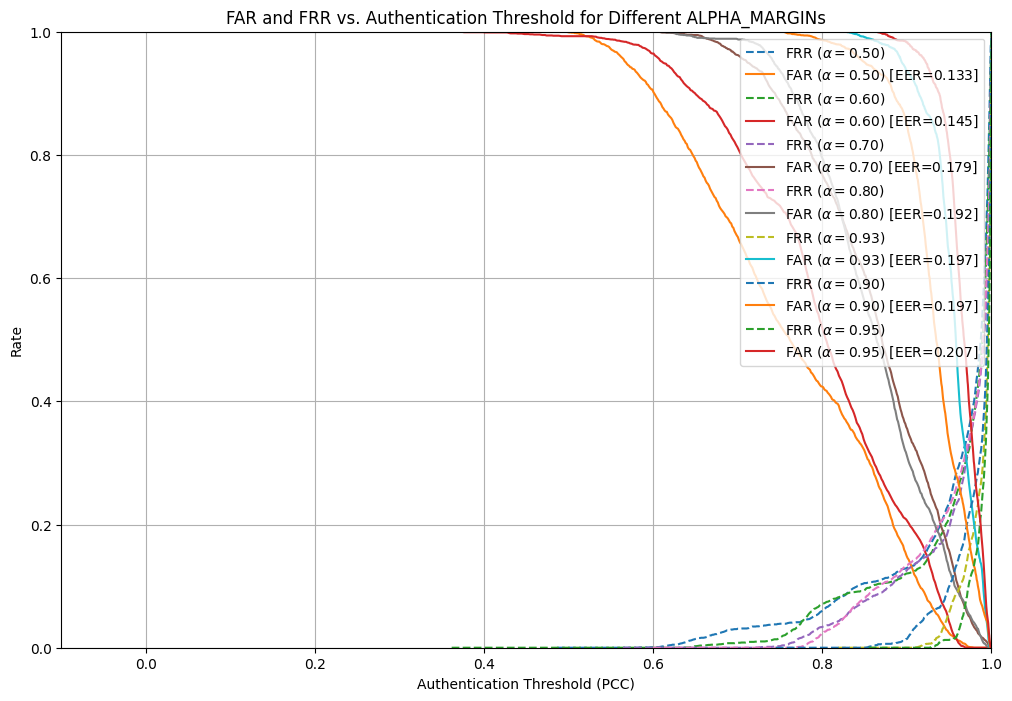


Summary of EERs by ALPHA_MARGIN (Sorted by EER):
  ALPHA_MARGIN=0.50: EER Threshold=0.9049, EER Rate=0.1335
  ALPHA_MARGIN=0.60: EER Threshold=0.9254, EER Rate=0.1452
  ALPHA_MARGIN=0.70: EER Threshold=0.9452, EER Rate=0.1793
  ALPHA_MARGIN=0.80: EER Threshold=0.9349, EER Rate=0.1923
  ALPHA_MARGIN=0.93: EER Threshold=0.9798, EER Rate=0.1973
  ALPHA_MARGIN=0.90: EER Threshold=0.9708, EER Rate=0.1974
  ALPHA_MARGIN=0.95: EER Threshold=0.9871, EER Rate=0.2068


In [83]:

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
# from tqdm.notebook import tqdm # Uncomment for progress bar

# Assumes:
# - build_cnn_encoder_fig4 is defined (from your initial CNN Encoder cell)
# - build_siamese_network is defined (from Code Block A)
# - SiameseContrastiveLoss class is defined (from Code Block A)
# - siamese_pair_generator is defined (from Code Block 2)
# - evaluate_authentication_performance is defined (from Code Block B)
# - calculate_far_frr_curve is defined (from Code Block B)
# - X_train_cnn, source_ids_train, X_val_cnn, source_ids_val are populated (from Code Block 1)
# - X_data_cnn (full), source_ids (full) are populated (from preprocessing)
# - BATCH_SIZE, EPOCHS, STEPS_PER_EPOCH_TRAIN, STEPS_PER_EPOCH_VAL are defined (from Code Block 4)
# - NUM_REGISTERED_PERSONS, NUM_REG_SEGMENTS_PER_PERSON_DB, FIXED_RANDOM_STATE are defined (e.g., 60, 15, 42)
# - SEGMENT_SAMPLES is defined


print("Starting ALPHA_MARGIN tuning process...")

# --- Define ALPHA_MARGIN values to test ---
# Choose a range that seems reasonable based on PCC scores (-1 to 1).
# Values between 0.5 and 0.9 might be interesting. Add more values for finer tuning.
alpha_margins_to_test = [0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95] # Example values, adjust as needed

# List to store results for each tuning run
tuning_results = []

# --- Loop through each ALPHA_MARGIN value ---
# Use tqdm for overall progress if installed
# for alpha_margin in tqdm(alpha_margins_to_test, desc="Tuning ALPHA_MARGIN"):
for alpha_margin in alpha_margins_to_test:
    print(f"\n\n--- Training and Evaluating with ALPHA_MARGIN = {alpha_margin:.2f} ---")

    # --- 1. Reset Model Weights ---
    # Recreate the CNN encoder instance to start fresh
    cnn_encoder_tuned = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
    print("CNN Encoder weights reset.")

    # --- 2. Define Siamese Network Structure (using the new encoder instance) ---
    siamese_network_tuned = build_siamese_network(cnn_encoder_tuned, input_shape=(SEGMENT_SAMPLES, 1))
    # siamese_network_tuned.summary() # Optional: print summary for each run

    # --- 3. Define Loss Function (with the current ALPHA_MARGIN) ---
    loss_fn_tuned = SiameseContrastiveLoss(margin=alpha_margin)
    print(f"Siamese Loss defined with margin = {loss_fn_tuned.get_margin():.2f}")

    # --- 4. Define Optimizer (new instance for each run) ---
    optimizer_tuned = tf.keras.optimizers.Adam(learning_rate=0.0005)
    print("New Optimizer instance created.")

    # --- 5. Compile Siamese Network ---
    siamese_network_tuned.compile(optimizer=optimizer_tuned, loss=loss_fn_tuned)
    print("Siamese network compiled.")

    # --- 6. Train Siamese Network ---
    print(f"\n  Starting training for {EPOCHS} epochs...")

    # Need tf.data.Datasets for training and validation (recreate or ensure access)
    # Assuming siamese_pair_generator, X_train_cnn, sources_with_multiple_segments_train, etc.
    # are defined globally from Code Block 2 setup.
    # Create tf.data.Datasets using the generator *functions* and the output_signature
    # Define the output signature matching the generator's yield: ((seg1, seg2), label)
    output_sig = (
        (
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32) # Label shape
    )

    # Check if enough data exists for generators (copied logic from Code Block 2)
    sources_with_multiple_segments_train, list_of_valid_sources_train = group_segments_by_source(X_train_cnn, source_ids_train) # Re-calculate just in case
    sources_with_multiple_segments_val, list_of_valid_sources_val = group_segments_by_source(X_val_cnn, source_ids_val)

    if len(list_of_valid_sources_train) >= 2:
        py_train_generator_fn = lambda: siamese_pair_generator(X_train_cnn, sources_with_multiple_segments_train, list_of_valid_sources_train, BATCH_SIZE)
        tf_train_dataset = tf.data.Dataset.from_generator(py_train_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
    else:
         print("  WARNING: Not enough diverse sources in training data. Skipping training.")
         tf_train_dataset = None

    if len(list_of_valid_sources_val) >= 2:
        py_val_generator_fn = lambda: siamese_pair_generator(X_val_cnn, sources_with_multiple_segments_val, list_of_valid_sources_val, BATCH_SIZE)
        tf_val_dataset = tf.data.Dataset.from_generator(py_val_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
    else:
         print("  WARNING: Not enough diverse sources in validation data. Training will proceed without validation.")
         tf_val_dataset = None


    if tf_train_dataset is not None:
        history = siamese_network_tuned.fit(
            tf_train_dataset,
            epochs=EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
            validation_data=tf_val_dataset,
            validation_steps=STEPS_PER_EPOCH_VAL if tf_val_dataset else None,
            verbose=0 # Set to 0 for quiet training during tuning loop
            # Use callbacks=[tqdm_callback] if you want a training progress bar per epoch (requires verbose=1)
        )
        print(f"  Training finished for ALPHA_MARGIN={alpha_margin:.2f}.")
    else:
        history = None
        print(f"  Training skipped for ALPHA_MARGIN={alpha_margin:.2f} due to lack of training data.")


    # --- 7. Authentication Evaluation ---
    # Use the *full* X_data_cnn and source_ids for this, with the fixed person split.
    # Need NUM_REGISTERED_PERSONS, NUM_REG_SEGMENTS_PER_PERSON_DB, FIXED_RANDOM_STATE defined globally
    if history is not None: # Only evaluate if training happened
         print(f"\n  Evaluating authentication for ALPHA_MARGIN={alpha_margin:.2f}...")
         genuine_scores, impostor_scores, _ = evaluate_authentication_performance(
             cnn_encoder_tuned, # Pass the TRAINED encoder
             X_data_cnn, # Use full data
             source_ids, # Use full source_ids
             NUM_REGISTERED_PERSONS,
             NUM_REG_SEGMENTS_PER_PERSON_DB,
             FIXED_RANDOM_STATE,
             evaluation_threshold=alpha_margin # Optionally print metrics at the alpha=threshold point
         )
         print(f"  Evaluation complete for ALPHA_MARGIN={alpha_margin:.2f}.")

         # --- 8. Calculate FAR/FRR Curve and EER ---
         threshold_range, far_values, frr_values, eer_threshold, eer_rate = calculate_far_frr_curve(
             genuine_scores, impostor_scores
         )

         if eer_threshold is not None:
              print(f"  EER for ALPHA_MARGIN={alpha_margin:.2f}: Threshold={eer_threshold:.4f}, Rate={eer_rate:.4f}")

              # --- 9. Store Results ---
              tuning_results.append({
                  'alpha_margin': alpha_margin,
                  'threshold_range': threshold_range,
                  'far_values': far_values,
                  'frr_values': frr_values,
                  'eer_threshold': eer_threshold,
                  'eer_rate': eer_rate,
                  'genuine_scores': genuine_scores, # Optionally store scores
                  'impostor_scores': impostor_scores, # Optionally store scores
                  # Add history.history if you want to plot train/val loss later per run
              })
         else:
             print(f"  Could not calculate curve/EER for ALPHA_MARGIN={alpha_margin:.2f}. Skipping result storage.")

    else:
        print(f"\n  Skipping evaluation for ALPHA_MARGIN={alpha_margin:.2f} due to skipped training.")


print("\n--- ALPHA_MARGIN Tuning Complete ---")
print(f"Evaluated {len(tuning_results)} ALPHA_MARGIN values.")

# --- 10. Plotting Comparison Curves ---
print("\nPlotting comparison of FAR/FRR curves for different ALPHA_MARGIN values...")

if len(tuning_results) > 0:
    plt.figure(figsize=(12, 8))

    # Sort results by EER rate to easily identify the best
    sorted_results = sorted(tuning_results, key=lambda x: x.get('eer_rate', float('inf')))

    for result in sorted_results:
        alpha = result['alpha_margin']
        thresholds = result['threshold_range']
        fars = result['far_values']
        frrs = result['frr_values']
        eer_thresh = result['eer_threshold']
        eer_rate = result['eer_rate']

        # Plot FRR curve
        plt.plot(thresholds, frrs, linestyle='--', label=f'FRR ($\\alpha={alpha:.2f}$)')

        # Plot FAR curve
        # Use a distinct color or marker for each FAR curve
        plt.plot(thresholds, fars, linestyle='-', label=f'FAR ($\\alpha={alpha:.2f}$) [EER={eer_rate:.3f}]')

        # Optional: Mark the EER point on the plot
        # if eer_thresh is not None and -1 <= eer_thresh <= 1:
        #     plt.plot(eer_thresh, eer_rate, 'o', color=plt.gca().lines[-1].get_color(), markersize=6) # Mark EER with matching color


    plt.title('FAR and FRR vs. Authentication Threshold for Different ALPHA_MARGINs')
    plt.xlabel('Authentication Threshold (PCC)')
    plt.ylabel('Rate')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xlim([-0.1, 1.0]) # Adjust limits based on expected score range
    plt.ylim([0.0, 1.0])

    plt.show()

    print("\nSummary of EERs by ALPHA_MARGIN (Sorted by EER):")
    for result in sorted_results:
         alpha = result['alpha_margin']
         eer_thresh = result['eer_threshold']
         eer_rate = result['eer_rate']
         print(f"  ALPHA_MARGIN={alpha:.2f}: EER Threshold={eer_thresh:.4f}, EER Rate={eer_rate:.4f}")


else:
    print("No tuning results available to plot.")

# Test with ALPHA_MARGIN=0.50: EER Threshold=0.9049


In [84]:
# =============================================================================
# Code Block Y: Train with Best Alpha Margin (0.50) and Evaluate at EER Threshold (0.9049)
# Place this cell AFTER necessary functions and data splits are defined globally.
# =============================================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt # Needed for plotting history
import random # Needed for persona split
# Ensure calculate_pcc_numpy, authenticate_segment, evaluate_authentication_performance
# group_segments_by_source, siamese_pair_generator, build_cnn_encoder_fig4,
# build_siamese_network, SiameseContrastiveLoss are defined globally.

print("--- Training Model with Best ALPHA_MARGIN (0.50) and Evaluating at EER Threshold (0.9049) ---")

# --- Define Best Parameters ---
BEST_TRAINING_ALPHA_MARGIN = 0.50 # The alpha margin that yielded the best EER during tuning
EPOCHS_FOR_FINAL_TRAINING = 100 # Use the same number of epochs as tuning runs (or more if planning longer training)
EER_AUTHENTICATION_THRESHOLD = 0.9049 # The estimated EER threshold from the tuning plot

# Assumes BATCH_SIZE, STEPS_PER_EPOCH_TRAIN, STEPS_PER_EPOCH_VAL are defined from Code Block 4/previous calculations
# Assumes NUM_REGISTERED_PERSONS, NUM_REG_SEGMENTS_PER_PERSON_DB, FIXED_RANDOM_STATE are defined globally (e.g., 60, 15, 42)
# Assumes X_train_cnn, source_ids_train, X_val_cnn, source_ids_val, X_data_cnn, source_ids are populated.


# --- 1. Recreate and Train Model with Best ALPHA_MARGIN ---

# Recreate the CNN encoder instance to start fresh
print("\nRecreating and training CNN Encoder with ALPHA_MARGIN = 0.50...")
cnn_encoder_best_alpha = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
print("CNN Encoder created.")

# Define Siamese Network Structure (using the new encoder instance)
siamese_network_best_alpha = build_siamese_network(cnn_encoder_best_alpha, input_shape=(SEGMENT_SAMPLES, 1))
# siamese_network_best_alpha.summary() # Optional: print summary

# Define Loss Function (with the best ALPHA_MARGIN)
loss_fn_best_alpha = SiameseContrastiveLoss(margin=BEST_TRAINING_ALPHA_MARGIN)
print(f"Siamese Loss defined with margin = {loss_fn_best_alpha.get_margin():.2f}")

# Define Optimizer (new instance for this training run)
optimizer_best_alpha = tf.keras.optimizers.Adam(learning_rate=0.0005)
print("New Optimizer instance created.")

# Compile Siamese Network
siamese_network_best_alpha.compile(optimizer=optimizer_best_alpha, loss=loss_fn_best_alpha)
print("Siamese network compiled.")


# Need tf.data.Datasets for training and validation (recreate datasets)
# Define the output signature matching the generator's yield: ((seg1, seg2), label)
if 'SEGMENT_SAMPLES' not in locals(): SEGMENT_SAMPLES = 1000 # Defensive check

output_sig = (
    (
        tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32) # Label shape
)

# Re-check if enough data exists for generators (copied logic from Code Block 2)
sources_with_multiple_segments_train, list_of_valid_sources_train = group_segments_by_source(X_train_cnn, source_ids_train)
sources_with_multiple_segments_val, list_of_valid_sources_val = group_segments_by_source(X_val_cnn, source_ids_val)

if len(list_of_valid_sources_train) >= 2:
    py_train_generator_fn = lambda: siamese_pair_generator(X_train_cnn, sources_with_multiple_segments_train, list_of_valid_sources_train, BATCH_SIZE)
    tf_train_dataset = tf.data.Dataset.from_generator(py_train_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
else:
     print("  WARNING: Not enough diverse sources in training data. Skipping training.")
     tf_train_dataset = None

if len(list_of_valid_sources_val) >= 2:
    py_val_generator_fn = lambda: siamese_pair_generator(X_val_cnn, sources_with_multiple_segments_val, list_of_valid_sources_val, BATCH_SIZE)
    tf_val_dataset = tf.data.Dataset.from_generator(py_val_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
else:
     print("  WARNING: Not enough diverse sources in validation data. Training will proceed without validation.")
     tf_val_dataset = None


# Train Siamese Network with best alpha
if tf_train_dataset is not None:
    print(f"\nStarting training for {EPOCHS_FOR_FINAL_TRAINING} epochs with ALPHA_MARGIN={BEST_TRAINING_ALPHA_MARGIN:.2f}...")
    history = siamese_network_best_alpha.fit(
        tf_train_dataset,
        epochs=EPOCHS_FOR_FINAL_TRAINING,
        steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
        validation_data=tf_val_dataset,
        validation_steps=STEPS_PER_EPOCH_VAL if tf_val_dataset else None,
        verbose=1 # Show progress during training
        # Use callbacks=[tqdm_callback] if you want a training progress bar per epoch
    )
    print(f"Training finished for ALPHA_MARGIN={BEST_TRAINING_ALPHA_MARGIN:.2f}.")

    # Optional: Plotting loss history for this training run
    # if history is not None and 'loss' in history.history:
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(history.history['loss'], label='Train Loss')
    #     if 'val_loss' in history.history:
    #         plt.plot(history.history['val_loss'], label='Validation Loss')
    #     plt.title(f'Siamese Contrastive Loss over Epochs (ALPHA_MARGIN={BEST_TRAINING_ALPHA_MARGIN:.2f})')
    #     plt.ylabel('Loss')
    #     plt.xlabel('Epoch')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()

else:
    print("\nTraining skipped due to lack of training data.")
    cnn_encoder_best_alpha = None # Ensure encoder is None if training failed



--- Training Model with Best ALPHA_MARGIN (0.50) and Evaluating at EER Threshold (0.9049) ---

Recreating and training CNN Encoder with ALPHA_MARGIN = 0.50...
CNN Encoder created.
Siamese Loss defined with margin = 0.50
New Optimizer instance created.
Siamese network compiled.

Starting training for 100 epochs with ALPHA_MARGIN=0.50...
Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0950 - val_loss: 0.0684
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0586 - val_loss: 0.0567
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0486 - val_loss: 0.0574
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0456 - val_loss: 0.0372
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0413 - val_loss: 0.0362
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0379 - val_loss: 0.0295
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0331 - val_loss: 0.0394
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

KeyError: 'Registered Persons'

In [85]:
# =============================================================================
# Code Block Z: Evaluate Trained Model (ALPHA_MARGIN=0.50) at Specific Threshold (0.9049)
# Place this cell AFTER the model training cell (with ALPHA_MARGIN=0.50).
# This assumes cnn_encoder_best_alpha holds the trained model.
# =============================================================================

import numpy as np
# Ensure calculate_pcc_numpy and authenticate_segment functions are defined globally
# Ensure evaluate_authentication_performance function is defined globally

# Assumes:
# - cnn_encoder_best_alpha (the TRAINED Keras Model) is available from training
# - X_data_cnn (full processed data) and source_ids (full) are available
# - NUM_REGISTERED_PERSONS (e.g., 60), NUM_REG_SEGMENTS_PER_PERSON_DB (e.g., 15),
#   and FIXED_RANDOM_STATE (e.g., 42) are defined globally.

print("--- Evaluating Trained Model (Alpha Margin 0.50) at Threshold 0.9049 ---")

# --- Define the Specific Authentication Threshold ---
EER_AUTHENTICATION_THRESHOLD = 0.9049 # The estimated EER threshold from the tuning plot


# --- Call the Authentication Evaluation Function ---
# The evaluate_authentication_performance function handles the reproducible person split,
# DB building, testing, and metric calculation at the specified threshold.

if 'cnn_encoder_best_alpha' not in locals() or cnn_encoder_best_alpha is None:
    print("\nError: Trained model 'cnn_encoder_best_alpha' is not available. Cannot perform evaluation.")
else:
    # Call the evaluate_authentication_performance function
    # It returns genuine_scores, impostor_scores, and metrics_at_eer_threshold
    genuine_scores_eval, impostor_scores_eval, metrics_at_eer_threshold = evaluate_authentication_performance(
        cnn_encoder_best_alpha, # Pass the trained encoder
        X_data_cnn, # Use full data for evaluation
        source_ids, # Use full source_ids
        NUM_REGISTERED_PERSONS, # Use global config for persons
        NUM_REG_SEGMENTS_PER_PERSON_DB, # Use global config for DB segments
        FIXED_RANDOM_STATE, # Use fixed random state for reproducible person split
        evaluation_threshold=EER_AUTHENTICATION_THRESHOLD # Pass the specific threshold for metric calculation
    )

    # --- Print the Metrics ---
    # Use the keys that are actually in the metrics dictionary
    if metrics_at_eer_threshold:
         print("\n--- Authentication Metrics at EER Threshold ---")
         # Access configuration details using the global variables
         print(f"Configuration (Training Margin: {BEST_TRAINING_ALPHA_MARGIN:.2f}, Auth Threshold: {EER_AUTHENTICATION_THRESHOLD:.4f}):")
         print(f"  Registered Persons (Config): {NUM_REGISTERED_PERSONS}")
         print(f"  DB Segments per Registered Person (Config): {NUM_REG_SEGMENTS_PER_PERSON_DB}")

         # Access counts from the returned metrics dictionary
         print(f"  Total Test Segments: {metrics_at_eer_threshold['Total Tests']}")
         print(f"    True Registered Tests (Segments): {metrics_at_eer_threshold['True Registered Tests']}")
         print(f"    True Unregistered Tests (Segments): {metrics_at_eer_threshold['True Unregistered Tests']}")

         print("\nResults:")
         print(f"Accuracy: {metrics_at_eer_threshold['Accuracy']:.4f}")
         print(f"Precision: {metrics_at_eer_threshold['Precision']:.4f}")
         print(f"Recall (TPR): {metrics_at_eer_threshold['Recall (TPR)']:.4f}")
         print(f"F1 Score: {metrics_at_eer_threshold['F1 Score']:.4f}")
         print(f"False Acceptance Rate (FAR / FPR): {metrics_at_eer_threshold['FAR']:.4f}")
         print(f"False Rejection Rate (FRR): {metrics_at_eer_threshold['FRR']:.4f}")

    else:
        print("\nAuthentication evaluation did not return metrics.")

# Note: genuine_scores_eval and impostor_scores_eval are also returned
# if you want to plot the score distribution for this specific run/threshold again.
# This code block focuses only on printing the metrics table.

--- Evaluating Trained Model (Alpha Margin 0.50) at Threshold 0.9049 ---

  --- Starting Authentication Evaluation (Random State: 42) ---
  Authentication Evaluation complete.

--- Authentication Metrics at EER Threshold ---
Configuration (Training Margin: 0.50, Auth Threshold: 0.9049):
  Registered Persons (Config): 60
  DB Segments per Registered Person (Config): 15
  Total Test Segments: 5472
    True Registered Tests (Segments): 2849
    True Unregistered Tests (Segments): 2623

Results:
Accuracy: 0.8487
Precision: 0.8417
Recall (TPR): 0.8736
F1 Score: 0.8574
False Acceptance Rate (FAR / FPR): 0.1784
False Rejection Rate (FRR): 0.1264


# HYP.P. TUNING 2

BLOCK C


In [86]:

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
# from tqdm.notebook import tqdm # Uncomment for progress bar

# Assumes:
# - build_cnn_encoder_fig4 is defined (from your initial CNN Encoder cell)
# - build_siamese_network is defined (from Code Block A)
# - SiameseContrastiveLoss class is defined (from Code Block A)
# - siamese_pair_generator is defined (from Code Block 2)
# - evaluate_authentication_performance is defined (from Code Block B)
# - calculate_far_frr_curve is defined (from Code Block B)
# - X_train_cnn, source_ids_train, X_val_cnn, source_ids_val are populated (from Code Block 1)
# - X_data_cnn (full), source_ids (full) are populated (from preprocessing)
# - BATCH_SIZE, EPOCHS, STEPS_PER_EPOCH_TRAIN, STEPS_PER_EPOCH_VAL are defined (from Code Block 4)
# - NUM_REGISTERED_PERSONS, NUM_REG_SEGMENTS_PER_PERSON_DB, FIXED_RANDOM_STATE are defined (e.g., 60, 15, 42)
# - SEGMENT_SAMPLES is defined


print("Starting ALPHA_MARGIN tuning process...")

# --- Define ALPHA_MARGIN values to test ---
# Your requested values: 0.1, 0.5, 1, 2, 3, 4
alpha_margins_to_test = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4] # Use floats

# WARNING about margins > 1 for PCC Loss:
print("\nWARNING: Testing ALPHA_MARGIN values > 1.0 for PCC loss.")
print("The PCC similarity metric is bounded between -1.0 and 1.0.")
print("A margin > 1.0 in SiameseContrastiveLoss(margin) means:")
print(" - Negative pairs are only penalized if similarity > margin (which is impossible if margin > 1).")
print("Training with margins > 1.0 might not converge well or may behave unexpectedly.")
print("Suggest focusing on margins between 0.0 and 1.0 for PCC.")
print("Proceeding with requested values: ", alpha_margins_to_test)


# List to store results for each tuning run
tuning_results = []

# --- Loop through each ALPHA_MARGIN value ---
# ... rest of Code Block C ...
# --- Loop through each ALPHA_MARGIN value ---
# Use tqdm for overall progress if installed
# for alpha_margin in tqdm(alpha_margins_to_test, desc="Tuning ALPHA_MARGIN"):
for alpha_margin in alpha_margins_to_test:
    print(f"\n\n--- Training and Evaluating with ALPHA_MARGIN = {alpha_margin:.2f} ---")

    # --- 1. Reset Model Weights ---
    # Recreate the CNN encoder instance to start fresh
    cnn_encoder_tuned = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
    print("CNN Encoder weights reset.")

    # --- 2. Define Siamese Network Structure (using the new encoder instance) ---
    siamese_network_tuned = build_siamese_network(cnn_encoder_tuned, input_shape=(SEGMENT_SAMPLES, 1))
    # siamese_network_tuned.summary() # Optional: print summary for each run

    # --- 3. Define Loss Function (with the current ALPHA_MARGIN) ---
    loss_fn_tuned = SiameseContrastiveLoss(margin=alpha_margin)
    print(f"Siamese Loss defined with margin = {loss_fn_tuned.get_margin():.2f}")

    # --- 4. Define Optimizer (new instance for each run) ---
    optimizer_tuned = tf.keras.optimizers.Adam(learning_rate=0.0005)
    print("New Optimizer instance created.")

    # --- 5. Compile Siamese Network ---
    siamese_network_tuned.compile(optimizer=optimizer_tuned, loss=loss_fn_tuned)
    print("Siamese network compiled.")

    # --- 6. Train Siamese Network ---
    print(f"\n  Starting training for {EPOCHS} epochs...")

    # Need tf.data.Datasets for training and validation (recreate or ensure access)
    # Assuming siamese_pair_generator, X_train_cnn, sources_with_multiple_segments_train, etc.
    # are defined globally from Code Block 2 setup.
    # Create tf.data.Datasets using the generator *functions* and the output_signature
    # Define the output signature matching the generator's yield: ((seg1, seg2), label)
    output_sig = (
        (
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32) # Label shape
    )

    # Check if enough data exists for generators (copied logic from Code Block 2)
    sources_with_multiple_segments_train, list_of_valid_sources_train = group_segments_by_source(X_train_cnn, source_ids_train) # Re-calculate just in case
    sources_with_multiple_segments_val, list_of_valid_sources_val = group_segments_by_source(X_val_cnn, source_ids_val)

    if len(list_of_valid_sources_train) >= 2:
        py_train_generator_fn = lambda: siamese_pair_generator(X_train_cnn, sources_with_multiple_segments_train, list_of_valid_sources_train, BATCH_SIZE)
        tf_train_dataset = tf.data.Dataset.from_generator(py_train_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
    else:
         print("  WARNING: Not enough diverse sources in training data. Skipping training.")
         tf_train_dataset = None

    if len(list_of_valid_sources_val) >= 2:
        py_val_generator_fn = lambda: siamese_pair_generator(X_val_cnn, sources_with_multiple_segments_val, list_of_valid_sources_val, BATCH_SIZE)
        tf_val_dataset = tf.data.Dataset.from_generator(py_val_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
    else:
         print("  WARNING: Not enough diverse sources in validation data. Training will proceed without validation.")
         tf_val_dataset = None


    if tf_train_dataset is not None:
        history = siamese_network_tuned.fit(
            tf_train_dataset,
            epochs=EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
            validation_data=tf_val_dataset,
            validation_steps=STEPS_PER_EPOCH_VAL if tf_val_dataset else None,
            verbose=0 # Set to 0 for quiet training during tuning loop
            # Use callbacks=[tqdm_callback] if you want a training progress bar per epoch (requires verbose=1)
        )
        print(f"  Training finished for ALPHA_MARGIN={alpha_margin:.2f}.")
    else:
        history = None
        print(f"  Training skipped for ALPHA_MARGIN={alpha_margin:.2f} due to lack of training data.")


    # --- 7. Authentication Evaluation ---
    # Use the *full* X_data_cnn and source_ids for this, with the fixed person split.
    # Need NUM_REGISTERED_PERSONS, NUM_REG_SEGMENTS_PER_PERSON_DB, FIXED_RANDOM_STATE defined globally
    if history is not None: # Only evaluate if training happened
         print(f"\n  Evaluating authentication for ALPHA_MARGIN={alpha_margin:.2f}...")
         genuine_scores, impostor_scores, _ = evaluate_authentication_performance(
             cnn_encoder_tuned, # Pass the TRAINED encoder
             X_data_cnn, # Use full data
             source_ids, # Use full source_ids
             NUM_REGISTERED_PERSONS,
             NUM_REG_SEGMENTS_PER_PERSON_DB,
             FIXED_RANDOM_STATE,
             evaluation_threshold=alpha_margin # Optionally print metrics at the alpha=threshold point
         )
         print(f"  Evaluation complete for ALPHA_MARGIN={alpha_margin:.2f}.")

         # --- 8. Calculate FAR/FRR Curve and EER ---
         threshold_range, far_values, frr_values, eer_threshold, eer_rate = calculate_far_frr_curve(
             genuine_scores, impostor_scores
         )

         if eer_threshold is not None:
              print(f"  EER for ALPHA_MARGIN={alpha_margin:.2f}: Threshold={eer_threshold:.4f}, Rate={eer_rate:.4f}")

              # --- 9. Store Results ---
              tuning_results.append({
                  'alpha_margin': alpha_margin,
                  'threshold_range': threshold_range,
                  'far_values': far_values,
                  'frr_values': frr_values,
                  'eer_threshold': eer_threshold,
                  'eer_rate': eer_rate,
                  'genuine_scores': genuine_scores, # Optionally store scores
                  'impostor_scores': impostor_scores, # Optionally store scores
                  # Add history.history if you want to plot train/val loss later per run
              })
         else:
             print(f"  Could not calculate curve/EER for ALPHA_MARGIN={alpha_margin:.2f}. Skipping result storage.")

    else:
        print(f"\n  Skipping evaluation for ALPHA_MARGIN={alpha_margin:.2f} due to skipped training.")


print("\n--- ALPHA_MARGIN Tuning Complete ---")
print(f"Evaluated {len(tuning_results)} ALPHA_MARGIN values.")

# --- 10. Plotting Comparison Curves ---
print("\nPlotting comparison of FAR/FRR curves for different ALPHA_MARGIN values...")

if len(tuning_results) > 0:
    plt.figure(figsize=(12, 8))

    # Sort results by EER rate to easily identify the best
    sorted_results = sorted(tuning_results, key=lambda x: x.get('eer_rate', float('inf')))

    for result in sorted_results:
        alpha = result['alpha_margin']
        thresholds = result['threshold_range']
        fars = result['far_values']
        frrs = result['frr_values']
        eer_thresh = result['eer_threshold']
        eer_rate = result['eer_rate']

        # Plot FRR curve
        plt.plot(thresholds, frrs, linestyle='--', label=f'FRR ($\\alpha={alpha:.2f}$)')

        # Plot FAR curve
        # Use a distinct color or marker for each FAR curve
        plt.plot(thresholds, fars, linestyle='-', label=f'FAR ($\\alpha={alpha:.2f}$) [EER={eer_rate:.3f}]')

        # Optional: Mark the EER point on the plot
        # if eer_thresh is not None and -1 <= eer_thresh <= 1:
        #     plt.plot(eer_thresh, eer_rate, 'o', color=plt.gca().lines[-1].get_color(), markersize=6) # Mark EER with matching color


    plt.title('FAR and FRR vs. Authentication Threshold for Different ALPHA_MARGINs')
    plt.xlabel('Authentication Threshold (PCC)')
    plt.ylabel('Rate')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xlim([-0.1, 1.0]) # Adjust limits based on expected score range
    plt.ylim([0.0, 1.0])

    plt.show()

    print("\nSummary of EERs by ALPHA_MARGIN (Sorted by EER):")
    for result in sorted_results:
         alpha = result['alpha_margin']
         eer_thresh = result['eer_threshold']
         eer_rate = result['eer_rate']
         print(f"  ALPHA_MARGIN={alpha:.2f}: EER Threshold={eer_thresh:.4f}, EER Rate={eer_rate:.4f}")


else:
    print("No tuning results available to plot.")

Starting ALPHA_MARGIN tuning process...

The PCC similarity metric is bounded between -1.0 and 1.0.
A margin > 1.0 in SiameseContrastiveLoss(margin) means:
 - Negative pairs are only penalized if similarity > margin (which is impossible if margin > 1).
Training with margins > 1.0 might not converge well or may behave unexpectedly.
Suggest focusing on margins between 0.0 and 1.0 for PCC.
Proceeding with requested values:  [0.01, 0.05, 1, 2, 3, 4]


--- Training and Evaluating with ALPHA_MARGIN = 0.01 ---
CNN Encoder weights reset.
Siamese Loss defined with margin = 0.01
New Optimizer instance created.
Siamese network compiled.

  Starting training for 100 epochs...
  Training finished for ALPHA_MARGIN=0.01.

  Evaluating authentication for ALPHA_MARGIN=0.01...

  --- Starting Authentication Evaluation (Random State: 42) ---
  Authentication Evaluation complete.
  Evaluation complete for ALPHA_MARGIN=0.01.
  Estimated EER (crossing): Threshold=0.9974, Rate=0.3492
  EER for ALPHA_MARGIN=0

ValueError: Margin must be a number between -1.0 and 1.0, got 2

# TESTING 2( BEST MODEL)-CHANGE LATER


In [87]:
# =============================================================================
# Code Block Y: Train with Best Alpha Margin (0.50) and Evaluate at EER Threshold (0.9049)
# Place this cell AFTER necessary functions and data splits are defined globally.
# =============================================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt # Needed for plotting history
import random # Needed for persona split
# Ensure calculate_pcc_numpy, authenticate_segment, evaluate_authentication_performance
# group_segments_by_source, siamese_pair_generator, build_cnn_encoder_fig4,
# build_siamese_network, SiameseContrastiveLoss are defined globally.

print("--- Training Model with Best ALPHA_MARGIN (0.50) and Evaluating at EER Threshold (0.9049) ---")

# --- Define Best Parameters ---
BEST_TRAINING_ALPHA_MARGIN = 3.5 # The alpha margin that yielded the best EER during tuning
EPOCHS_FOR_FINAL_TRAINING = 200 # Use the same number of epochs as tuning runs (or more if planning longer training)
EER_AUTHENTICATION_THRESHOLD = 0.95 # The estimated EER threshold from the tuning plot

# Assumes BATCH_SIZE, STEPS_PER_EPOCH_TRAIN, STEPS_PER_EPOCH_VAL are defined from Code Block 4/previous calculations
# Assumes NUM_REGISTERED_PERSONS, NUM_REG_SEGMENTS_PER_PERSON_DB, FIXED_RANDOM_STATE are defined globally (e.g., 60, 15, 42)
# Assumes X_train_cnn, source_ids_train, X_val_cnn, source_ids_val, X_data_cnn, source_ids are populated.


# --- 1. Recreate and Train Model with Best ALPHA_MARGIN ---

# Recreate the CNN encoder instance to start fresh
print("\nRecreating and training CNN Encoder with ALPHA_MARGIN = 0.50...")
cnn_encoder_best_alpha = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
print("CNN Encoder created.")

# Define Siamese Network Structure (using the new encoder instance)
siamese_network_best_alpha = build_siamese_network(cnn_encoder_best_alpha, input_shape=(SEGMENT_SAMPLES, 1))
# siamese_network_best_alpha.summary() # Optional: print summary

# Define Loss Function (with the best ALPHA_MARGIN)
loss_fn_best_alpha = SiameseContrastiveLoss(margin=BEST_TRAINING_ALPHA_MARGIN)
print(f"Siamese Loss defined with margin = {loss_fn_best_alpha.get_margin():.2f}")

# Define Optimizer (new instance for this training run)
optimizer_best_alpha = tf.keras.optimizers.Adam(learning_rate=0.0005)
print("New Optimizer instance created.")

# Compile Siamese Network
siamese_network_best_alpha.compile(optimizer=optimizer_best_alpha, loss=loss_fn_best_alpha)
print("Siamese network compiled.")


# Need tf.data.Datasets for training and validation (recreate datasets)
# Define the output signature matching the generator's yield: ((seg1, seg2), label)
if 'SEGMENT_SAMPLES' not in locals(): SEGMENT_SAMPLES = 1000 # Defensive check

output_sig = (
    (
        tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32) # Label shape
)

# Re-check if enough data exists for generators (copied logic from Code Block 2)
sources_with_multiple_segments_train, list_of_valid_sources_train = group_segments_by_source(X_train_cnn, source_ids_train)
sources_with_multiple_segments_val, list_of_valid_sources_val = group_segments_by_source(X_val_cnn, source_ids_val)

if len(list_of_valid_sources_train) >= 2:
    py_train_generator_fn = lambda: siamese_pair_generator(X_train_cnn, sources_with_multiple_segments_train, list_of_valid_sources_train, BATCH_SIZE)
    tf_train_dataset = tf.data.Dataset.from_generator(py_train_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
else:
     print("  WARNING: Not enough diverse sources in training data. Skipping training.")
     tf_train_dataset = None

if len(list_of_valid_sources_val) >= 2:
    py_val_generator_fn = lambda: siamese_pair_generator(X_val_cnn, sources_with_multiple_segments_val, list_of_valid_sources_val, BATCH_SIZE)
    tf_val_dataset = tf.data.Dataset.from_generator(py_val_generator_fn, output_signature=output_sig).prefetch(tf.data.AUTOTUNE)
else:
     print("  WARNING: Not enough diverse sources in validation data. Training will proceed without validation.")
     tf_val_dataset = None


# Train Siamese Network with best alpha
if tf_train_dataset is not None:
    print(f"\nStarting training for {EPOCHS_FOR_FINAL_TRAINING} epochs with ALPHA_MARGIN={BEST_TRAINING_ALPHA_MARGIN:.2f}...")
    history = siamese_network_best_alpha.fit(
        tf_train_dataset,
        epochs=EPOCHS_FOR_FINAL_TRAINING,
        steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
        validation_data=tf_val_dataset,
        validation_steps=STEPS_PER_EPOCH_VAL if tf_val_dataset else None,
        verbose=1 # Show progress during training
        # Use callbacks=[tqdm_callback] if you want a training progress bar per epoch
    )
    print(f"Training finished for ALPHA_MARGIN={BEST_TRAINING_ALPHA_MARGIN:.2f}.")

    # Optional: Plotting loss history for this training run
    # if history is not None and 'loss' in history.history:
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(history.history['loss'], label='Train Loss')
    #     if 'val_loss' in history.history:
    #         plt.plot(history.history['val_loss'], label='Validation Loss')
    #     plt.title(f'Siamese Contrastive Loss over Epochs (ALPHA_MARGIN={BEST_TRAINING_ALPHA_MARGIN:.2f})')
    #     plt.ylabel('Loss')
    #     plt.xlabel('Epoch')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()

else:
    print("\nTraining skipped due to lack of training data.")
    cnn_encoder_best_alpha = None # Ensure encoder is None if training failed



--- Training Model with Best ALPHA_MARGIN (0.50) and Evaluating at EER Threshold (0.9049) ---

Recreating and training CNN Encoder with ALPHA_MARGIN = 0.50...
CNN Encoder created.
Siamese Loss defined with margin = 0.01
New Optimizer instance created.
Siamese network compiled.

Starting training for 200 epochs with ALPHA_MARGIN=0.01...
Epoch 1/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.2180 - val_loss: 0.1769
Epoch 2/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1516 - val_loss: 0.1362
Epoch 3/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1385 - val_loss: 0.1353
Epoch 4/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1317 - val_loss: 0.1190
Epoch 5/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1239 - val_loss: 0.1102
Epoch 6/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1151 - val_loss: 0.0997
Epoch 7/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1082 - val_loss: 0.1165
Epoch 8/200
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

In [88]:
# =============================================================================
# Code Block Z: Evaluate Trained Model (ALPHA_MARGIN=0.50) at Specific Threshold (0.9049)
# Place this cell AFTER the model training cell (with ALPHA_MARGIN=0.50).
# This assumes cnn_encoder_best_alpha holds the trained model.
# =============================================================================

import numpy as np
# Ensure calculate_pcc_numpy and authenticate_segment functions are defined globally
# Ensure evaluate_authentication_performance function is defined globally

# Assumes:
# - cnn_encoder_best_alpha (the TRAINED Keras Model) is available from training
# - X_data_cnn (full processed data) and source_ids (full) are available
# - NUM_REGISTERED_PERSONS (e.g., 60), NUM_REG_SEGMENTS_PER_PERSON_DB (e.g., 15),
#   and FIXED_RANDOM_STATE (e.g., 42) are defined globally.

print("--- Evaluating Trained Model (Alpha Margin 0.50) at Threshold 0.9049 ---")

# --- Define the Specific Authentication Threshold ---
EER_AUTHENTICATION_THRESHOLD = 0.9974 # The estimated EER threshold from the tuning plot


# --- Call the Authentication Evaluation Function ---
# The evaluate_authentication_performance function handles the reproducible person split,
# DB building, testing, and metric calculation at the specified threshold.

if 'cnn_encoder_best_alpha' not in locals() or cnn_encoder_best_alpha is None:
    print("\nError: Trained model 'cnn_encoder_best_alpha' is not available. Cannot perform evaluation.")
else:
    # Call the evaluate_authentication_performance function
    # It returns genuine_scores, impostor_scores, and metrics_at_eer_threshold
    genuine_scores_eval, impostor_scores_eval, metrics_at_eer_threshold = evaluate_authentication_performance(
        cnn_encoder_best_alpha, # Pass the trained encoder
        X_data_cnn, # Use full data for evaluation
        source_ids, # Use full source_ids
        NUM_REGISTERED_PERSONS, # Use global config for persons
        NUM_REG_SEGMENTS_PER_PERSON_DB, # Use global config for DB segments
        FIXED_RANDOM_STATE, # Use fixed random state for reproducible person split
        evaluation_threshold=EER_AUTHENTICATION_THRESHOLD # Pass the specific threshold for metric calculation
    )

    # --- Print the Metrics ---
    # Use the keys that are actually in the metrics dictionary
    if metrics_at_eer_threshold:
         print("\n--- Authentication Metrics at EER Threshold ---")
         # Access configuration details using the global variables
         print(f"Configuration (Training Margin: {BEST_TRAINING_ALPHA_MARGIN:.2f}, Auth Threshold: {EER_AUTHENTICATION_THRESHOLD:.4f}):")
         print(f"  Registered Persons (Config): {NUM_REGISTERED_PERSONS}")
         print(f"  DB Segments per Registered Person (Config): {NUM_REG_SEGMENTS_PER_PERSON_DB}")

         # Access counts from the returned metrics dictionary
         print(f"  Total Test Segments: {metrics_at_eer_threshold['Total Tests']}")
         print(f"    True Registered Tests (Segments): {metrics_at_eer_threshold['True Registered Tests']}")
         print(f"    True Unregistered Tests (Segments): {metrics_at_eer_threshold['True Unregistered Tests']}")

         print("\nResults:")
         print(f"Accuracy: {metrics_at_eer_threshold['Accuracy']:.4f}")
         print(f"Precision: {metrics_at_eer_threshold['Precision']:.4f}")
         print(f"Recall (TPR): {metrics_at_eer_threshold['Recall (TPR)']:.4f}")
         print(f"F1 Score: {metrics_at_eer_threshold['F1 Score']:.4f}")
         print(f"False Acceptance Rate (FAR / FPR): {metrics_at_eer_threshold['FAR']:.4f}")
         print(f"False Rejection Rate (FRR): {metrics_at_eer_threshold['FRR']:.4f}")

    else:
        print("\nAuthentication evaluation did not return metrics.")



--- Evaluating Trained Model (Alpha Margin 0.50) at Threshold 0.9049 ---

  --- Starting Authentication Evaluation (Random State: 42) ---
  Authentication Evaluation complete.

--- Authentication Metrics at EER Threshold ---
Configuration (Training Margin: 0.01, Auth Threshold: 0.9974):
  Registered Persons (Config): 60
  DB Segments per Registered Person (Config): 15
  Total Test Segments: 5472
    True Registered Tests (Segments): 2849
    True Unregistered Tests (Segments): 2623

Results:
Accuracy: 0.6961
Precision: 0.6363
Recall (TPR): 0.9716
F1 Score: 0.7690
False Acceptance Rate (FAR / FPR): 0.6031
False Rejection Rate (FRR): 0.0284
